# Parcial práctico 2 Machine Learning
# Henry Saenz & Kelly Beltrán


### Análisis descriptivo de ``Default Probability Prediction``
- Descripción de tipos de variables
- Reducción de nombres extensos en columnas
- calcular número de
observaciones, media, desviación estándar, mínimo, máximo, cuartiles
- Realizar conteo de datos
faltantes y su porcentaje
- histograma o diagrama de barras para la variable respuesta e independientes según corresponda, seleccionar un mínimo de 10 variables independientes, para este análisis.
Análisis de simetría, datos atípicos y dispersión, etc,... por medio de boxplot(). Análisis bivariado.
Trazado de scatterplot() y regplot() para un mínimo de 10 pares de variables explicativas. En cada
figura agregar un análisis y descripción.




### Importación de librerías

Se realiza la instalación y carga respectiva de las librerías necesarias para la limpieza, análisis, visualización, estandarización, escalamiento, inspección, etc. De los datos.

In [2]:
!pip install statsmodels
!pip install sklearn
!pip install dask
!pip install tabulate
!pip install missingno dask
!pip install dask[dataframe]
!pip install ace_tools

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import dask.dataframe as dd #Lectura de csv grandes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from tabulate import tabulate
from scipy.stats import shapiro
from scipy.stats import normaltest
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
import statsmodels.api as sm
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.stats import chi2_contingency
from scipy.stats import kstest

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Carga de archivos

In [ ]:
 !ls '/content/drive/My Drive/'

'Coaching entry form (1).csv'			    'KPI (2).csv'
'Coaching tactic.csv'				    'KPI (2).gsheet'
'Coaching tactic.gsheet'			     ML2_Henry.ipynb
'Colab Notebooks'				     module_UnderA.ipynb
' Data_viz'					    'Parcial 2'
 days_data_eurusd_futures-20240419T231103Z-002.zip  'Qué es la justicia.odp'
 df_cateim.csv					    'Team distribution.csv'
 df_vif-d.csv					     train_data.csv
 final_results					     train_labels.csv
 for_drive					     X_clasificacion.parquet
'Hoja de cálculo sin título.gsheet'		     X_res.parquet
'KPI (2) (1).gsheet'				     y_clasificacion.parquet
'KPI (2) (2).gsheet'				     y_res.parquet
'KPI (2) (3).gsheet'


In [4]:
data_train = dd.read_csv('/content/drive/My Drive/train_data.csv')

In [5]:
label_train = dd.read_csv('/content/drive/My Drive/train_labels.csv')

### Análisis Exploratorio de los Datos (EDA)

Inicialmente se realiza la carga e inspecciòn superficial de las caraterísticas de los datos, tales como el nùmero de observaciones, filas, columnas, tipos de variables, se concantena el conjunto de datos de las variables predictoras y el conjunto de datos de variable respuesta.

Es relevante mencionar que el conjunto de datos ```train``` posee 5531451 de onservaciones o registros de transacciones y 190 variables/columnas, de las cuales 185 son flotantes, 1 entero y 4 caracteres.



In [ ]:
data_train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 190 entries, customer_ID to D_145
dtypes: float64(185), int64(1), string(4)

In [ ]:
n_columnas = len(data_train.columns)
n_filas = len(data_train)

print(f"El conjunto de entrenamiento para las predictoras tiene {n_filas} filas y {n_columnas} columnas.")

El conjunto de entrenamiento para las predictoras tiene 5531451 filas y 190 columnas.


In [ ]:
print(tabulate(data_train.tail(10), headers='keys', tablefmt='fancy_grid'))

╒═══════╤══════════════════════════════════════════════════════════════════╤════════════╤══════════╤════════════╤═════════════╤══════════╤═════════════╤═══════════╤═════════════╤════════════╤════════╤════════════╤════════════╤═════════════╤══════════╤════════════╤════════════╤══════════╤══════════╤════════════╤════════╤═══════════╤═══════════╤═════════════╤═══════════╤════════════╤════════════╤════════════╤══════════╤══════════╤══════════╤════════╤════════════╤════════════╤═════════════╤═════════╤═════════════╤═══════════╤═══════════╤════════════╤═══════════╤══════════╤═══════════╤═════════════╤════════════╤══════════════╤════════════╤══════════╤═══════════╤═════════════╤════════════╤══════════╤═══════════╤════════╤════════╤═════════════╤══════════╤════════════╤══════════╤═════════════╤════════╤═════════════╤════════╤══════════╤═════════════╤═════════════╤════════════╤═════════════╤════════════╤════════════╤════════════╤═════════════╤══════════╤════════════╤════════╤═════════════╤═════

Observando las características superficiales del conjunto de datos de tipo `label`, que contiene la etiqueta para cada cliente que realizò una transaciòn y la variable respuesta o `target` que indica si fue o no una transacciòn fraudulenta. El conjunto de datos posee 458913 identificadores de cliente diferentes de dos variables.

In [ ]:
n_columnas = len(label_train.columns)
n_filas = len(label_train)

print(f"El conjunto de entrenamiento para la variable respuesta tiene {n_filas} filas y {n_columnas} columnas.")

El conjunto de entrenamiento para la variable respuesta tiene 458913 filas y 2 columnas.


In [ ]:
print(tabulate(label_train.tail(10), headers='keys', tablefmt='fancy_grid'))

╒════════╤══════════════════════════════════════════════════════════════════╤══════════╕
│        │ customer_ID                                                      │   target │
╞════════╪══════════════════════════════════════════════════════════════════╪══════════╡
│ 458903 │ fffec7d7e1ca804c86f1ffdaac389c33f8039ed35bf412b12d2e3548e49d54fa │        0 │
├────────┼──────────────────────────────────────────────────────────────────┼──────────┤
│ 458904 │ fffee056e120fb326c9413fca5a7ab6618cc49be9bb6b19c34f3fb13fd50fdd3 │        0 │
├────────┼──────────────────────────────────────────────────────────────────┼──────────┤
│ 458905 │ fffee847c5c1af7dbdd36d98fea882893256c422cde86cc927c7cce6e958dab4 │        0 │
├────────┼──────────────────────────────────────────────────────────────────┼──────────┤
│ 458906 │ fffef3305f19a11fb6c15f4ebe9be1bd664540e57c0a6aa2ed6a31c31c8069f8 │        0 │
├────────┼──────────────────────────────────────────────────────────────────┼──────────┤
│ 458907 │ ffff39cc22

Para poder identificar las variables o caracterìsticas de manera màs cercana, se extrae el nombre y tipo de cada una, se cambia el nombre de la variable `S_2` a `Date`, ya que esta representa la fecha en la que se realizó la transacción y se identifica que variables son las que corresponde a cada grupo.

In [ ]:
print(data_train.columns.tolist())

['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'D_49', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_63', 'D_64', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'D_66', 'B_20', 'D_68', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'D_73', 'P_4', 'D_74', 'D_75', 'D_76', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'R_9', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'B_29', 'B_30', 'S_18', 'D_86', 'D_87', 'R_17', 'R_18', 'D_88', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_2

In [ ]:
print(data_train.dtypes.tolist())

[string[pyarrow], string[pyarrow], dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), string[pyarrow], string[pyarrow], dtype('float6

### Cambiar nombre

In [5]:
rename_columns = {
    'S_2': 'Date'
}

data_train = data_train.rename(columns=rename_columns)

Las estadìsticas iniciales de los datos se identifican a continuaciòn ùnicamente con el 10% de los datos extraidos.

In [ ]:
df_describe = data_train.sample(frac=0.1).describe().compute()  # Muestra del 10% de los datos
table = tabulate(df_describe, headers='keys', tablefmt='grid')
print(table)

+-------+---------------+------------------+-----------------+------------------+------------------+---------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------+----------------+-----------------+-----------------+-----------------+----------------+------------------+----------------+------------------+------------------+------------------+-----------------+---------------+-----------------+------------------+------------------+------------------+------------------+----------------+------------------+----------------+------------------+-----------------+------------------+----------------+------------------+------------------+------------------+-----------------+-----------------+----------------+------------------+-----------------+-----------------+---------------+-----------------+------------------+------------------+------------------+-------

### Concatenar conjuntos de datos

Se verifica que las etiquetas únicas para cada cliente que se encuentran en el conjunto label coincidan con las etiquetas en el conjunto de entrenamiento para los valores de las predictoras. Se concluye que si coinciden todas por lo que se hace una concatenaión a través de un `left join` con la variable '`costumer_ID`'. Cada etiqueta de predicción para los clientes se agrega con base a esa llave.

In [ ]:
if 'customer_ID' in label_train.columns and 'customer_ID' in data_train.columns:
    # Encontrar los valores en común entre los 'customer_ID' de ambos DataFrames
    common_customer_ids = set(label_train['customer_ID']).intersection(set(data_train['customer_ID']))

    # Contar cuántos valores son comunes
    num_common_ids = len(common_customer_ids)

    # Mostrar el número de valores comunes y algunos ejemplos
    print(f"Número de customer_IDs en común: {num_common_ids}")
    print(f"Ejemplos de customer_IDs en común: {list(common_customer_ids)[:10]}")
else:
    print("'customer_ID' no se encuentra en ambos DataFrames.")

Número de customer_IDs en común: 458913
Ejemplos de customer_IDs en común: ['cc78f6810929e4badab36c5a6a0eadf22f4f00854d9aafdd8da0491ff1f3a184', '4ee9844a98c859f5d3f864c6fd71d48f3d8787c27d8f2365991e721d0c289d41', '35d750c24f6799ed92b239135595187420bc10091212ab6be81cddd1345f5c51', '1f9a0de2d4538bb2cb2de9a78d2f22a6e57aaaf1240c298ad68f3d7edd36496d', 'b8f3dbac0223003a1ddce30b86ee9872477607203abc8868d812cfdc6f2a9631', '6d11f33a83df1a4d09383d6ea2092aafba1eed1dfb21dd64be8b38a3e88137df', '4f84b89574a8ffee830a6db8e5a1eca02566eee4a5fcbab0f8fe249cd04415a1', '87122ab09e19ce698f67d6ddd5e151e19bef4ef483da7e5dc6d0043d3b1ff27b', '1aa7998e863639b6167a3e6ad04d0ce74e0044b8f4f24c6b469d48ed2b900619', '551241999843f9185d8eb28c2197e9235e35e3217d7bb27dea8f88f93c5e5756']


In [6]:
if 'customer_ID' in label_train.columns and 'customer_ID' in data_train.columns:

    # Unir los DataFrames usando 'customer_ID' como clave (merge left join)
    data = data_train.merge(label_train[['customer_ID', 'target']],
                                         on='customer_ID',
                                         how='left')

    print(tabulate(data.tail(10), headers = 'keys', tablefmt = 'grid'))
else:
    print("'customer_ID' no se encuentra en ambos DataFrames.")


+-------+------------------------------------------------------------------+------------+----------+------------+-------------+----------+-------------+-----------+-------------+------------+--------+------------+------------+-------------+----------+------------+------------+----------+----------+------------+--------+-----------+-----------+-------------+-----------+------------+------------+------------+----------+----------+----------+--------+------------+------------+-------------+---------+-------------+-----------+-----------+------------+-----------+----------+-----------+-------------+------------+--------------+------------+----------+-----------+-------------+------------+----------+-----------+--------+--------+-------------+----------+------------+----------+-------------+--------+-------------+--------+----------+-------------+-------------+------------+-------------+------------+------------+------------+-------------+----------+------------+--------+-------------+-----

Verificamos que al concatenar los conjuntos de datos se obtenga el mismo número de filas y columnas.

In [ ]:
n_columnas = len(data.columns)
n_filas = len(data)

print(f"El conjunto de entrenamiento para la variable respuesta tiene {n_filas} filas y {n_columnas} columnas.")

El conjunto de entrenamiento para la variable respuesta tiene 5531451 filas y 191 columnas.


**Identificar variables categóricas**

Se desea identificar cuales y cuantas variables de tipo categórico posee el conjunto de datos para su adecuado tratamiento y limpieza. Es clave mencionar que se encontraron 4 variables categóricas entre las que se destacan:
- `costumer_ID`
- `Date`
- `D_63`
- `D_64`

In [ ]:
# Seleccionar solo las columnas categóricas
categorical_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

# Mostrar el head del DataFrame solo con esas columnas
data_categorical_head = data[categorical_columns].head(10)

# Mostrar la salida
print(data_categorical_head)

   B_30  B_38  D_114  D_116  D_117  D_120  D_126 D_63 D_64  D_66  D_68
0   0.0   2.0    1.0    0.0    4.0    0.0    1.0   CR    O   NaN   6.0
1   0.0   2.0    1.0    0.0    4.0    0.0    1.0   CR    O   NaN   6.0
2   0.0   2.0    1.0    0.0    4.0    0.0    1.0   CR    O   NaN   6.0
3   0.0   2.0    1.0    0.0    4.0    0.0    1.0   CR    O   NaN   6.0
4   0.0   2.0    1.0    0.0    4.0    0.0    1.0   CR    O   NaN   6.0
5   0.0   2.0    1.0    0.0    4.0    0.0    1.0   CR    O   NaN   6.0
6   0.0   2.0    1.0    0.0    4.0    0.0    1.0   CR    O   NaN   6.0
7   0.0   2.0    1.0    0.0    4.0    0.0    1.0   CR    O   NaN   6.0
8   0.0   2.0    1.0    0.0    4.0    0.0    1.0   CR    O   NaN   6.0
9   0.0   2.0    1.0    0.0    4.0    0.0    1.0   CR    O   NaN   6.0


In [ ]:
def identify_categorical_vars_dask(data):
    """
    Identifies categorical (non-numerical) variables in a Dask DataFrame.

    Args:
        data: Dask DataFrame

    Returns:
        A list of column names that are considered categorical.
    """

    categorical_vars = []
    for col in data.columns:
        # Check for 'string[pyarrow]' or 'object' dtype
        if data[col].dtype == 'string' or str(data[col].dtype) == 'string[pyarrow]':
            categorical_vars.append(col)
    return categorical_vars

# Example usage:
categorical_columns = identify_categorical_vars_dask(data)
print("Categorical columns:", categorical_columns)

Categorical columns: ['customer_ID', 'Date', 'D_63', 'D_64']


### Anàlisis de datos faltantes



Para poder hacer cualquier tipo de análisis o inferencias se debe contar con la menor cantidad de datos ausentes posible, es por eso que el análisis de datos faltantes y revisión de inconsistencias en los mismos es clave para nuestro objetivo de análisis.
1.  En primera instancia se contabiliza el número de datos faltantes por columnas y la proporciòn de los mismos. Se muestran los resultados en una columna o lista.
2.  En segunda instancia se dividen los datos dependiendo su tipo para poder observar grypalmente como se distribuye o comporta la cantidad de datos faltantes por grupo. Los grupos son los siguientes:
- `D_*` = Delinquency variables
- `S_*` = Spend variables
- `P_*` = Payment variables
- `B_*` = Balance variables
- `R_*` = Risk variables


Se realizan funciones para calcular el porcentaje de datod faltanes y el conteo de datos faltantes por variable para cada grupo y organizarlos en una tabla de información.

In [ ]:
missing_percentage = data.isna().mean() * 100
missing_count = data.isna().sum()
missing_values_count = data.isnull().sum()

In [ ]:
# Calcular el porcentaje de datos faltantes por columna
total_rows = 5531451  # Computar el número de filas
missing_percentage = (missing_values_count / total_rows) * 100

# Crear un DataFrame con conteo y porcentaje (computar para pasar a pandas)
missing_values_count = missing_values_count.compute()
missing_percentage = missing_percentage.compute()

In [ ]:
# Crear un DataFrame para mostrar el conteo y porcentaje
missing_data_summary = pd.DataFrame({
    'Column': data.columns,
    'Datos Faltantes': missing_values_count,
    'Porcentaje (%)': missing_percentage
})

# Ordenar el DataFrame por el conteo de datos faltantes en orden descendente
missing_data_summary = missing_data_summary.sort_values(by='Datos Faltantes', ascending=False)

Los datos de cada grupo se dividen en una lista que permite identificar su categoría con base a la letra con la que inician. En este caso, la división de datos se establece con base a los siguientes grupos:
- `delinquency_columns`: Para las variables que inician con `'D_'`
- `spend_columns`: Para las variables que inician con `'S_'`
- `payment_columns`: Para las variables que inician con `'P_'`
- `balance_columns`: Para las variables que inician con `'B_'`
- `risk_columns`: Para las variables que inician con `'R_'`

In [ ]:
# Asignar las columnas a cada grupo según el criterio de nombre
delinquency_columns = [col for col in data.columns if col.startswith('D_')]
spend_columns = [col for col in data.columns if col.startswith('S_')]
payment_columns = [col for col in data.columns if col.startswith('P_')]
balance_columns = [col for col in data.columns if col.startswith('B_')]
risk_columns = [col for col in data.columns if col.startswith('R_')]

De forma descendente se muestra una lista para cada división o grupo de datos en la que se presenta su respectiva variable intragrupal con su número de datos faltantes y porcentaje de falta. Se destaca la alta presencia de datos faltantes en grupos como:
- *Delinquency variables*
- *Spend variables*

Lo que podría sugerir una posible dificultad en captación o e extracción de dichos datos, teniendo en cuenta que la mayoría de las variables de esos grupos que poseen datos faltantes se encuentran por encima del 50%.

In [ ]:
# Función para filtrar y mostrar datos faltantes por grupo
def show_missing_by_group(group_columns, group_name):
    group_df = missing_data_summary[missing_data_summary['Column'].isin(group_columns)]
    print(f"\n{group_name} - Missing Data Summary:")
    print(group_df.to_string(index=False))

# Mostrar los datos faltantes por cada grupo de variables
show_missing_by_group(delinquency_columns, "Delinquency Variables")
show_missing_by_group(spend_columns, "Spend Variables")
show_missing_by_group(payment_columns, "Payment Variables")
show_missing_by_group(balance_columns, "Balance Variables")
show_missing_by_group(risk_columns, "Risk Variables")


Delinquency Variables - Missing Data Summary:
Column  Datos Faltantes  Porcentaje (%)
  D_87          5527586       99.930127
  D_88          5525447       99.891457
 D_108          5502513       99.476846
 D_110          5500117       99.433530
 D_111          5500117       99.433530
  D_73          5475595       98.990211
 D_134          5336752       96.480146
 D_138          5336752       96.480146
 D_137          5336752       96.480146
 D_136          5336752       96.480146
 D_135          5336752       96.480146
 D_106          4990102       90.213255
 D_132          4988874       90.191055
  D_49          4985917       90.137597
  D_76          4908954       88.746226
  D_66          4908097       88.730733
  D_42          4740137       85.694278
 D_142          4587043       82.926577
  D_53          4084585       73.842921
  D_82          4058614       73.373406
  D_50          3142402       56.809723
 D_105          3021431       54.622756
  D_56          2990943       54.

**Conteo por grupos de variables**

Para cada grupo de variabes se realiza un proceso de insoección y cintei en cuanto a cuantas variables lo conforman, se organizan los grupos de forma descendente del que mayor posee variables al que posee menor número de variables:
- D_: 96
- B_: 40
- R_: 28
- S_: 21
- P_: 3

In [ ]:
delinquency_df = data[[col for col in data.columns if col.startswith('D_')]]
spend_df = data[[col for col in data.columns if col.startswith('S_')]]
payment_df = data[[col for col in data.columns if col.startswith('P_')]]
balance_df = data[[col for col in data.columns if col.startswith('B_')]]
risk_df = data[[col for col in data.columns if col.startswith('R_')]]

print(f"Delinquency variables: {delinquency_df.shape[1]}")
print(f"Spend variables: {spend_df.shape[1]}")
print(f"Payment variables: {payment_df.shape[1]}")
print(f"Balance variables: {balance_df.shape[1]}")
print(f"Risk variables: {risk_df.shape[1]}")

Delinquency variables: 96
Spend variables: 21
Payment variables: 3
Balance variables: 40
Risk variables: 28


Se observa el contenido de cada conjunto de datos extraído para verificar que se haya filtrado correctamente sin inconsistencias.

In [ ]:
# spend_df.tail()

,S_3,S_5,S_6,S_7,S_8,S_9,S_11,S_12,S_13,S_15,...,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27
21602,0.090743,0.036700,0.000038,0.055695,0.705097,0.021471,0.483833,0.188514,0.511308,0.204409,...,0.006024,0.000671,0.003172,0.004446,0.971546,0.132063,0.975162,0.970563,0.006208,0.257406
21603,0.079886,0.008777,0.004619,0.049632,0.705059,0.025450,0.244838,0.188050,0.423013,0.203718,...,0.000252,0.000642,0.009408,0.007979,0.878800,0.137596,0.900471,0.974740,0.004722,0.253864
21604,0.100503,0.004308,0.009737,0.051331,0.326980,0.025570,0.800476,0.192534,0.006100,0.200470,...,0.006164,0.003940,0.006900,0.007489,0.862615,0.138715,0.883456,0.972630,0.002910,0.345503
21605,0.101802,0.004883,0.005403,0.057164,0.327939,0.017040,0.965168,0.187689,0.003913,0.209341,...,0.001121,0.001741,0.005462,0.005034,0.872319,0.132014,0.886145,0.975976,0.001877,0.208531
21606,0.119165,0.004580,0.005609,0.065466,0.006674,0.005854,0.280465,0.191495,0.007736,0.505329,...,0.002432,0.008365,0.006033,0.009264,0.295251,0.131636,0.080514,0.974690,0.005346,0.000568


### Identificar variables con ausencia de datos superior a 50%

De acuerdo a `Rubin, 1987` en ***Statistical Analysis with Missing Data***, si la Data fue extraída de encuestas y la presencia de datos faltantes es cercana al 20%, 30% y màximo al 50% e sposible imputar, sin embargo con un margen de error e incertidumbre cada vez mayor. Por lo que se recomienda, dado que los datos son altamente incompletos, que la imputación puede resultar demasiado incierta.

Se realizará un análisis de datos faltantes para variables con un porcentaje de *`missing data`* superior al 50%, observar si existe correlación entre la distribución de los datos faltantes o son endependientes o patrón independiente. Esto se hace con el objetivo de garantizar la viabilidad de la eliminación de los datos faltantes.

Se lista cada grupo y el número de variables con datos faltantes por encima del 50%:
1. `Delinquency Variables: `
- Posee 23 variables por encima de 50% de datos faltantes. Es clave mencionar que 12 de ellas están por encima o igual al 90% con una distribución aparentemente correlacionada o similar. 3 alrededor de 50%-55% con una distribución aparentemente similar y 6 entre 70% - 90% con una distribución similar, es decir, se podría inspeccionar agrupaciones en dichas distribuciones.

2. `Spend Variables:`
- Posee unicamente una variable con datos faltantes alrededor del 53% Por lo que podría ser eliminada del conjunto de datos.

3. `Balance Variables:`
- Posee 4 variables con datos faltantes superior al 50%, de entre ellas, 3 por encima del 90% y 1 alrededor del 56%. Se podría señalar una relación en la distribución de las concentradas por encima del 90%.

4. `Risk Variables`
- Posee unicamente dos variables con datos faltantes por encima del 80%, por lo que pueden ser eliminadas.


In [ ]:
# Filtrar las columnas que tienen más del 50% de datos faltantes
missing_above_50 = missing_data_summary[missing_data_summary['Porcentaje (%)'] > 50]

# Función para mostrar los datos faltantes por grupo (D_, S_, P_, B_, R_) y el conteo de variables por encima del 50%
def show_missing_above_50_by_group(group_columns, group_name):
    group_df = missing_above_50[missing_above_50['Column'].isin(group_columns)]
    if not group_df.empty:  # Verificamos si el grupo tiene columnas con más del 50% de faltantes
        count_above_50 = group_df.shape[0]  # Contar el número de columnas en este grupo con más del 50% de faltantes
        print(f"\n{group_name} - Columnas con más del 50% de datos faltantes (Total: {count_above_50}):")
        print(group_df[['Column', 'Porcentaje (%)']].to_string(index=False))
    else:
        print(f"\n{group_name} - No hay columnas con más del 50% de datos faltantes.")

# Mostrar los datos faltantes por cada grupo de variables con más del 50% de datos faltantes y el conteo
show_missing_above_50_by_group(delinquency_columns, "Delinquency Variables")
show_missing_above_50_by_group(spend_columns, "Spend Variables")
show_missing_above_50_by_group(payment_columns, "Payment Variables")
show_missing_above_50_by_group(balance_columns, "Balance Variables")
show_missing_above_50_by_group(risk_columns, "Risk Variables")


Delinquency Variables - Columnas con más del 50% de datos faltantes (Total: 23):
Column  Porcentaje (%)
  D_87       99.930127
  D_88       99.891457
 D_108       99.476846
 D_110       99.433530
 D_111       99.433530
  D_73       98.990211
 D_134       96.480146
 D_138       96.480146
 D_137       96.480146
 D_136       96.480146
 D_135       96.480146
 D_106       90.213255
 D_132       90.191055
  D_49       90.137597
  D_76       88.746226
  D_66       88.730733
  D_42       85.694278
 D_142       82.926577
  D_53       73.842921
  D_82       73.373406
  D_50       56.809723
 D_105       54.622756
  D_56       54.071581

Spend Variables - Columnas con más del 50% de datos faltantes (Total: 1):
Column  Porcentaje (%)
   S_9       53.035686

Payment Variables - No hay columnas con más del 50% de datos faltantes.

Balance Variables - Columnas con más del 50% de datos faltantes (Total: 4):
Column  Porcentaje (%)
  B_39       99.391986
  B_42       98.707789
  B_29       93.104594
  B

`Visualización de datos faltants`

Para observar visualmente la concentración de datos faltantes, se realiza una matriz o gráfica de datos faltantes y observar la distribución de los mismos por grupo de división. Posterior a ello, analizaremos si hay alguna relación entre los datos faltantes de cada grupo mediante un gràfico de violín y finalmente con base a la literatura `(Rubin, 1987)` se eliminarán los datos con una proporción de datos faltantes igual o superior al 55% y se mostrará un resumen comparativo de dicha eliminación.

### Matriz de datos faltantes por grupo

Para observar la tendencia de los datos faltantes por en cada variable, se gráficará una matriz por grupo que permita identificar si los datos faltantes de cada columna se presenta en la misma observación o en observaciones diferentes, especialmente en los datos que poseen similar distribución de ausencia de datos.

1. `Delinquency:` Los valores faltantes en amarillo y los presentes en morado. Se observa que las variables hacia el centro y el extremo derecho presentan una mayor cantidad de datos faltantes, lo que podría sugerir una posible correlación estructural entre las variables que comparten datos faltantes. Por ejemplo, grupos de variables parecen tener una tendencia similar en términos de la proporción de valores faltantes, lo que sugiere que estos valores podrían estar asociados a ciertos eventos o características comunes en los registros.

2. `Spend:` La gráfica evidencia una concentración significativa de datos faltantes en las primeras variables (0 a 5), donde gran parte de las observaciones tiene vacíos (en amarillo). A partir de la variable 6, se nota una ausencia casi completa de datos faltantes, lo que sugiere que ciertas variables están mucho más completas que otras. Este patrón indica que las variables con mayor cantidad de datos faltantes podrían compartir características o eventos que afectan su registro, mientras que las variables posteriores muestran una mayor consistencia.

3. `Payment:` Se observa una distribución homogénea de los datos faltantes en las tres variables del conjunto de "Payment". Las líneas amarillas, que representan los valores faltantes, están presentes de manera esporádica a lo largo de las observaciones, pero la mayor parte de los datos está completa (en morado). No se observa una concentración significativa de datos faltantes en ningún rango de observaciones en particular, lo que indica que los faltantes podrían estar distribuidos de forma relativamente uniforme. Este patrón sugiere que no hay una clara correlación entre las observaciones respecto a los valores faltantes.

4. `Balance:` Se observa que los datos faltantes se concentran principalmente en las columnas 15, 28, y en las últimas columnas del gráfico (35 a 39) lo que sugiere que la distribución de los valores faltantes está agrupada en ciertas variables clave.

5. `Risk:` La matriz de Risk presenta que los datos faltantes están fuertemente concentrados en las columnas 7 y 24-26 con una relació o distribución aparente. La columna 7 destaca por tener una gran cantidad de valores faltantes a lo largo de todas las observaciones. De forma similar, las últimas columnas también presentan un patrón constante de valores faltantes. El resto de las columnas (0-6 y 8-23) muestran pocos o ningún dato faltante, indicando que la mayoría de las variables en este grupo están completas.

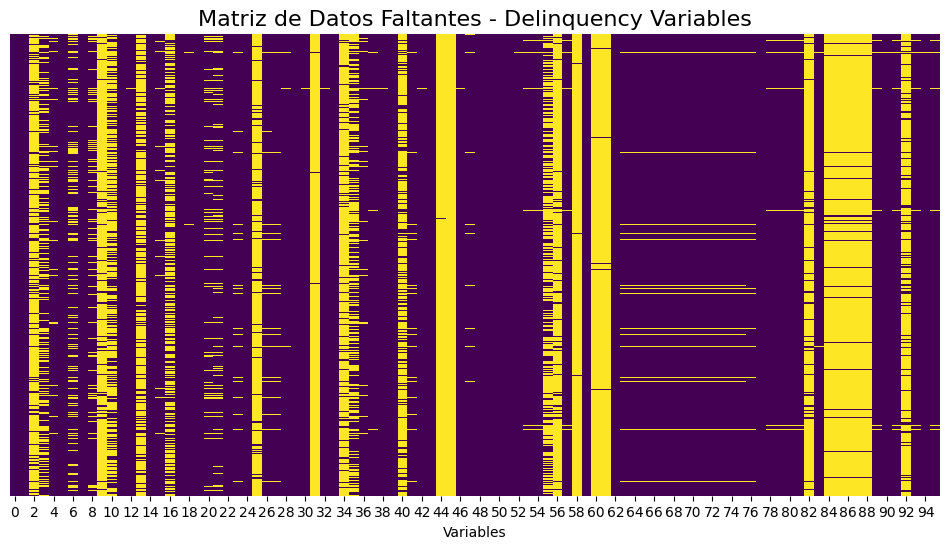

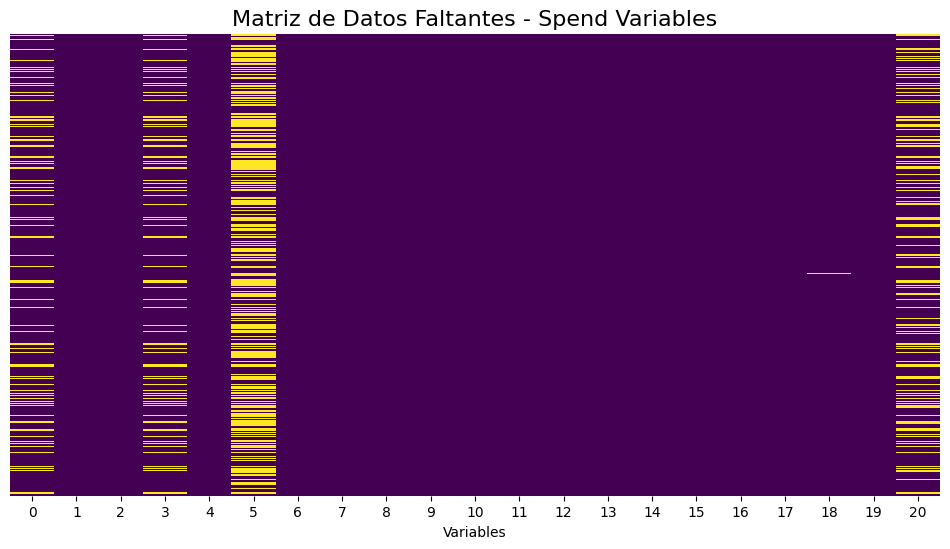

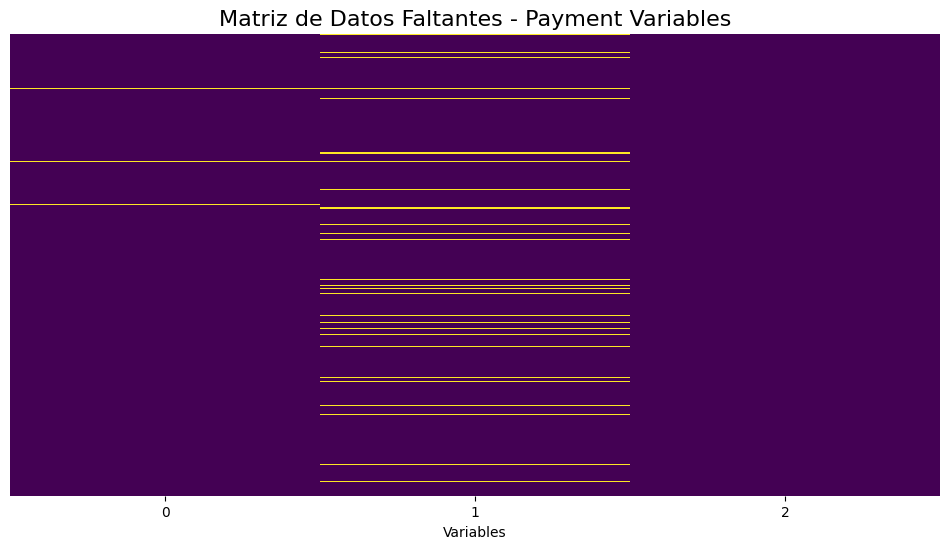

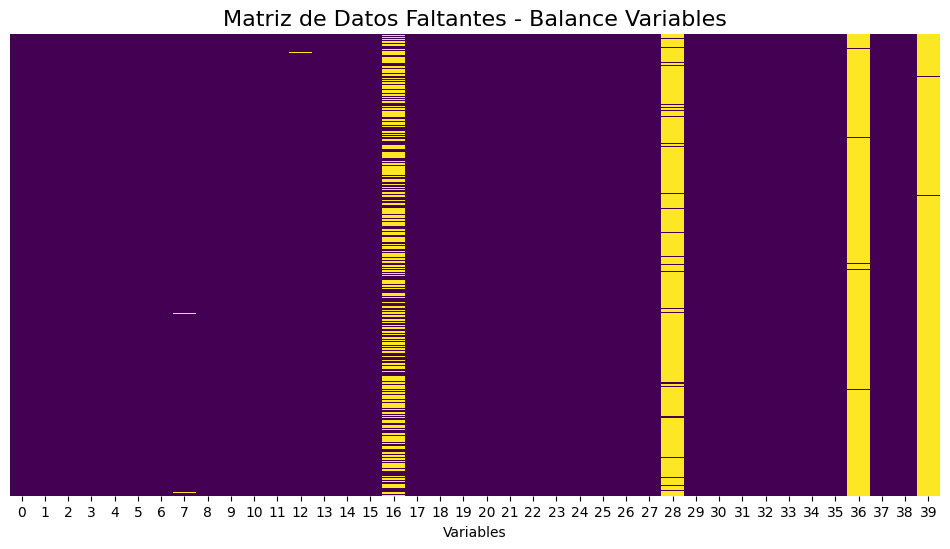

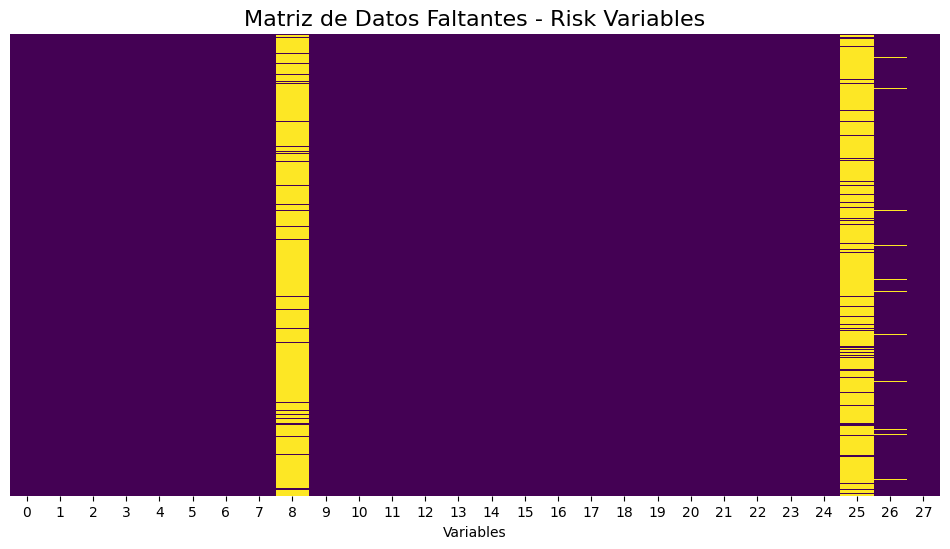

In [ ]:
# Crear una matriz de datos faltantes (True = faltante, False = no faltante)
missing_matrix = data.isnull()

# Función para mostrar la matriz de calor de datos faltantes
def plot_missing_heatmap(group_columns, group_name):
    group_df = data[group_columns]  # Filtrar las columnas del grupo
    if group_df.isnull().values.any():  # Solo graficar si hay datos faltantes
        plt.figure(figsize=(12, 6))
        sns.heatmap(group_df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
        plt.title(f'Matriz de Datos Faltantes - {group_name}', fontsize=16)
        plt.xlabel('Variables')
        plt.show()
    else:
        print(f"\n{group_name} - No hay datos faltantes para graficar.")

# Mostrar la matriz de calor para cada grupo
plot_missing_heatmap(delinquency_columns, "Delinquency Variables")
plot_missing_heatmap(spend_columns, "Spend Variables")
plot_missing_heatmap(payment_columns, "Payment Variables")
plot_missing_heatmap(balance_columns, "Balance Variables")
plot_missing_heatmap(risk_columns, "Risk Variables")

### Top 10 Variables faltantes por grupo

Para poder observar si los grupos de cada variable poseen una distribución similar gráficamos un ranking para cada grupo de variables.

Se presentan los isguientes hallazgos:
- Para el grupo Delinquency existen 10 variables cuya proporción de datos faltantes está por encima del 95%
- Para el grupo Spend, existen 4 variables por encima del 20% de datos faltantes con posibilidad de imputación, y una de las cuales está por encima del 50%.
- El grupo de Payment posee 2 variables con menos del 6% de datos faltantes, lo que sugiere robustes al momento de capturarla o recuoerarla.
- El grupo de Balance posee 1 variable superior al 50% de datos faltantes y 3 por encima del 98% de datos faltantes, estas ùltimas sugieren una relación entre la distribución de ausencia.
- Para el grupo de Risk hay dos variables por encima del 85% En datos faltantes.

In [ ]:
# Función para graficar los datos faltantes por grupo con el top 10 de columnas
def plot_missing_by_group_interactive(group_columns, group_name):
    group_df = missing_data_summary[missing_data_summary['Column'].isin(group_columns)]

    if not group_df.empty:  # Solo graficar si el grupo tiene columnas
        # Ordenar por porcentaje de datos faltantes y tomar el top 10
        top_10_group_df = group_df.sort_values(by='Porcentaje (%)', ascending=False).head(10)

        # Crear el gráfico de barras interactivo con Plotly
        fig = px.bar(top_10_group_df, x='Column', y='Porcentaje (%)',
                     title=f"Top 10 Variables con Datos Faltantes en {group_name}",
                     labels={'Porcentaje (%)': 'Porcentaje de Datos Faltantes (%)', 'Column': 'Variables'},
                     height=500)

        # Personalizar el gráfico
        fig.update_layout(
            xaxis_tickangle=-90,  # Rotar etiquetas de columnas
            template='plotly_dark',  # Usar un tema oscuro para el gráfico
            title_x=0.5,  # Centrar el título
            title_font=dict(size=20),  # Ajustar tamaño del título
            yaxis=dict(tickfont=dict(size=14)),  # Ajustar tamaño de las etiquetas en el eje Y
            xaxis=dict(tickfont=dict(size=12)),  # Ajustar tamaño de las etiquetas en el eje X
            margin=dict(l=40, r=40, t=80, b=120)  # Ajustar márgenes para mejorar la legibilidad
        )

        # Mostrar el gráfico interactivo
        fig.show()
    else:
        print(f"\n{group_name} - No hay columnas con datos faltantes para graficar.")



In [ ]:
# Graficar los datos faltantes por cada grupo de variables
plot_missing_by_group_interactive(delinquency_columns, "Delinquency Variables")
plot_missing_by_group_interactive(spend_columns, "Spend Variables")
plot_missing_by_group_interactive(payment_columns, "Payment Variables")
plot_missing_by_group_interactive(balance_columns, "Balance Variables")
plot_missing_by_group_interactive(risk_columns, "Risk Variables")

### Comparación dentro del grupo

Se desea confirmar si hay alguna relación entre la distribución interna de los porcentajes de datos faltantes para cada grupo, por lo que inicialmente se indaga sobre la normalidad de las variables  establecer cuales mètodos paranètricos o no paramétricos se debe implementr. Se inspecciona visualmente a tavés un gáfico de `quantil-quantil`, luego se aplica una prueba de normalidad Kolmogorov-Smirniv (n>50) y finalmente se inspecciona

`QQ.Plot`


1. `Delinquency:`

- La gráfica muestra una desviación significativa de la línea de normalidad. Los puntos en los extremos se separan claramente de la línea roja, lo que sugiere que los datos no siguen una distribución normal. En particular, hay una asimetría en los valores altos y bajos.
2. `Balance:`

- En este caso, los datos muestran una gran desviación de la normalidad. Los puntos en los cuartiles extremos están muy alejados de la línea roja, especialmente hacia el final derecho, lo que indica una fuerte desviación positiva con algunos valores atípicos elevados.
3. `Risk:`

- El Q-Q plot de las variables de "Risk" muestra que los puntos no siguen la línea de normalidad, especialmente en los extremos superiores. La curva se aleja significativamente, sugiriendo que los datos presentan una distribución no normal, con valores atípicos hacia el extremo positivo.
4. `Spend:`

- Similar a los anteriores, los puntos en el Q-Q plot para "Spend" también se alejan de la línea de normalidad, con mayor énfasis en los extremos, indicando una falta de normalidad en la distribución de los datos. La curva muestra una tendencia positiva significativa.
5. `Payment:`

- En contraste con los demás gráficos, los puntos en el Q-Q plot para "Payment" se ajustan perfectamente a la línea de normalidad. Esto sugiere que los datos de esta variable siguen una distribución muy cercana a la normal.

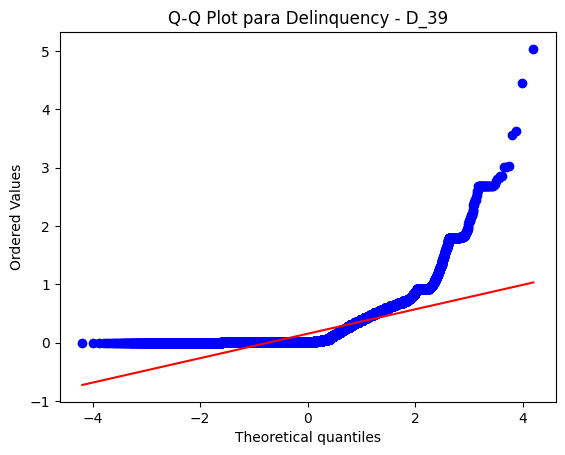

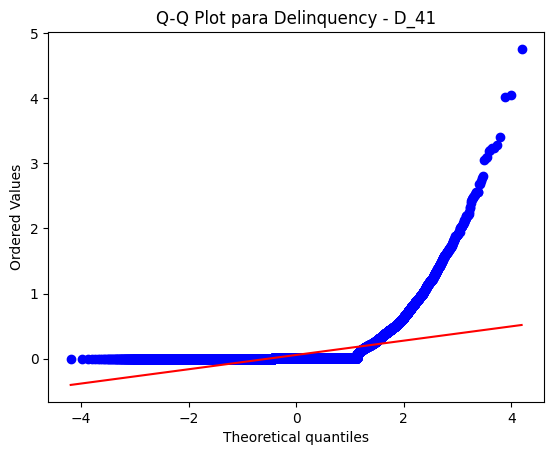

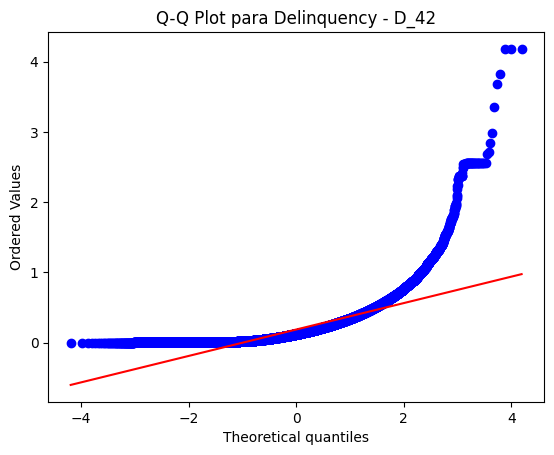

KeyboardInterrupt: 

In [ ]:
def qq_plot(data, group_name):
    # Get the length of the data
    data_len = len(data)

    # Take a sample, but limit size to data length if smaller than 5000
    sample_size = min(data_len, 50000)
    sample = np.random.choice(data, size=sample_size, replace=False)

    stats.probplot(sample, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot para {group_name}")
    plt.show()

# Generar Q-Q plot para cada grupo
qq_plot(delinquency_columns, "Delinquency")
qq_plot(balance_columns, "Balance")
qq_plot(risk_columns, "Risk")
qq_plot(spend_columns, "Spend")
qq_plot(payment_columns, "Payment")

### Prueba de normalidad


De los cinco grupos de datos, solo Delinquency y Balance muestran una clara evidencia de que NO siguen una distribución normal, mientras que Risk, Spend y Payment parecen seguir una distribución normal, con p-valores mayores a 0.05.

In [ ]:
# Crear los DataFrames filtrados por cada grupo de columnas seleccionadas
delinquency_df_filtered = data[delinquency_columns]  # Filtrar las columnas de 'Delinquency'
balance_df_filtered = data[balance_columns]          # Filtrar las columnas de 'Balance'
risk_df_filtered = data[risk_columns]                # Filtrar las columnas de 'Risk'
spend_df_filtered = data[spend_columns]              # Filtrar las columnas de 'Spend'
payment_df_filtered = data[payment_columns]          # Filtrar las columnas de 'Payment'

# Función para calcular la proporción de datos faltantes para un conjunto de columnas
def calculate_missing_proportion(df):
    missing_proportion = df.isnull().mean() * 100  # Calcular el porcentaje de faltantes
    return missing_proportion

# Calcular la proporción de datos faltantes para cada grupo de columnas filtradas
delinquency_pct = calculate_missing_proportion(delinquency_df_filtered)
balance_pct = calculate_missing_proportion(balance_df_filtered)
risk_pct = calculate_missing_proportion(risk_df_filtered)
spend_pct = calculate_missing_proportion(spend_df_filtered)
payment_pct = calculate_missing_proportion(payment_df_filtered)

In [ ]:
from scipy.stats import kstest
# Función para realizar la prueba de Kolmogorov-Smirnov
def check_normality_ks(data, group_name):
    # Normalizar los datos a una distribución estándar (media 0, desviación estándar 1)
    data_standardized = (data - np.mean(data)) / np.std(data)
    stat, p_value = kstest(data_standardized, 'norm')
    print(f"\nPrueba de Kolmogorov-Smirnov para {group_name}:")
    print(f"Estadístico KS: {stat}, p-valor: {p_value}")
    if p_value > 0.05:
        print(f"Los datos de {group_name} parecen seguir una distribución normal.")
    else:
        print(f"Los datos de {group_name} NO parecen seguir una distribución normal.")

# Verificar normalidad usando la prueba de Kolmogorov-Smirnov para cada grupo
check_normality_ks(delinquency_pct, "Delinquency")
check_normality_ks(balance_pct, "Balance")
check_normality_ks(risk_pct, "Risk")
check_normality_ks(spend_pct, "Spend")
check_normality_ks(payment_pct, "Payment")


Prueba de Kolmogorov-Smirnov para Delinquency:
Estadístico KS: 0.38892192951992316, p-valor: 1.3806601630201662e-13
Los datos de Delinquency NO parecen seguir una distribución normal.

Prueba de Kolmogorov-Smirnov para Balance:
Estadístico KS: 0.5157874614177522, p-valor: 2.063325017393879e-10
Los datos de Balance NO parecen seguir una distribución normal.

Prueba de Kolmogorov-Smirnov para Risk:
Estadístico KS: 0.5034690564314298, p-valor: 4.2836639905861185e-07
Los datos de Risk NO parecen seguir una distribución normal.

Prueba de Kolmogorov-Smirnov para Spend:
Estadístico KS: 0.4658232947053126, p-valor: 0.00010723452921834826
Los datos de Spend NO parecen seguir una distribución normal.

Prueba de Kolmogorov-Smirnov para Payment:
Estadístico KS: 0.36743685762111983, p-valor: 0.684984915004008
Los datos de Payment parecen seguir una distribución normal.


### Comparación entre grupos

Para proceder con el proceso de eliminación de variables con más de 55% de datos faltantes se debe inspeccionar si hay una posible correlación entre el patrón de ausencia o datos faltates entre los diferentes grupos de los cuales se dividieron los datos. Si existe una correlación no se procederá a eliminar las variables de cada grupo y se inspeccionará otro método de imputación pertinente. Por el contrario, si no existe una correlación aparente, se procede a eliminar de manera separada las variables.

In [ ]:
# Añadir una columna que identifique el grupo basado en el prefijo de las columnas
def assign_group(row):
    if row['Column'].startswith('D_'):
        return 'Delinquency'
    elif row['Column'].startswith('S_'):
        return 'Spend'
    elif row['Column'].startswith('P_'):
        return 'Payment'
    elif row['Column'].startswith('B_'):
        return 'Balance'
    elif row['Column'].startswith('R_'):
        return 'Risk'
    else:
        return 'Other'

# Añadir la columna 'Group' al DataFrame para categorizar por prefijo
missing_data_summary['Group'] = missing_data_summary.apply(assign_group, axis=1)

# Filtramos solo las columnas que tienen algún porcentaje de datos faltantes
filtered_data = missing_data_summary[missing_data_summary['Porcentaje (%)'] >= 0]


**Gráfico de violín para la distribución de proporción de datos faltantes entre grupos**

La gráfica muestra la distribución del porcentaje de datos faltantes en diferentes grupos de variables. El grupo Delinquency destaca por tener una mayor dispersión y concentración de datos faltantes en un rango alto, con varios puntos por encima del 50%, lo que sugiere que tiene más variables afectadas por la falta de datos. En contraste, grupos como Payment y Spend presentan porcentajes de faltantes mucho más bajos y una distribución más concentrada cerca del 0%, lo que indica menor presencia de datos faltantes.

La amplia variabilidad entre los grupos sugiere que los datos faltantes son independientes entre ellos y tienen patrones distintos según el grupo.

In [ ]:
# Crear el gráfico de violín interactivo con Plotly
fig = px.violin(filtered_data, x='Group', y='Porcentaje (%)',
                box=True,  # Añadir una caja para mostrar estadísticos
                points='all',  # Mostrar todos los puntos de datos
                title='Distribución del Porcentaje de Datos Faltantes por Grupo')

# Personalizar la apariencia del gráfico
fig.update_layout(
    title_x=0.5,  # Centrar el título
    title_font=dict(size=20),  # Ajustar tamaño del título
    yaxis_title='Porcentaje de Datos Faltantes (%)',  # Etiqueta del eje Y
    xaxis_title='Grupo de Variables',  # Etiqueta del eje X
    xaxis_tickangle=-45,  # Rotar las etiquetas del eje X
    template='plotly_white',  # Usar un tema claro para el gráfico
    yaxis=dict(tickfont=dict(size=14)),  # Ajustar tamaño de las etiquetas en el eje Y
    xaxis=dict(tickfont=dict(size=12)),  # Ajustar tamaño de las etiquetas en el eje X
    height=600  # Ajustar la altura del gráfico
)

# Mostrar el gráfico interactivo
fig.show()

In [ ]:
# Calcular el porcentaje promedio de datos faltantes en cada grupo
delinquency_pct = filtered_data[filtered_data['Group'] == 'Delinquency']['Porcentaje (%)']
balance_pct = filtered_data[filtered_data['Group'] == 'Balance']['Porcentaje (%)']
risk_pct = filtered_data[filtered_data['Group'] == 'Risk']['Porcentaje (%)']
spend_pct = filtered_data[filtered_data['Group'] == 'Spend']['Porcentaje (%)']
payment_pct = filtered_data[filtered_data['Group'] == 'Payment']['Porcentaje (%)']

#### **Test de Kruskal-Wallis para diferencia entre grupos**

Resultado de Kruskal-Wallis:

- **Hipótesis nula ($H_0$):** Las distribuciones de los diferentes grupos son iguales. No hay diferencia significativa entre las medianas de los grupos.


- **Hipótesis alternativa ($H_A$):**  Al menos un grupo tiene una distribución significativamente diferente. Hay diferencias significativas entre las medianas de los grupos.


Hay una diferencia significativa en los porcentajes de datos faltantes entre los grupos (Delinquency, Balance, Risk, Spend, Payment), con un p-valor extremadamente bajo (9.21e-05).
Esto significa que las medianas de los porcentajes de datos faltantes de al menos uno de los grupos son significativamente diferentes de las de los otros grupos.
Independencia:

Si tus datos representan grupos independientes (por ejemplo, diferentes categorías de datos faltantes como Delinquency, Balance, etc.), entonces puedes asumir independencia.
Si las observaciones dentro de los grupos no están relacionadas entre sí ni con las observaciones de otros grupos, este supuesto se cumple.

In [ ]:
from scipy.stats import kruskal

# Realizar la prueba de Kruskal-Wallis para los diferentes grupos
stat, p_value = kruskal(delinquency_pct, balance_pct, risk_pct, spend_pct, payment_pct)

print(f"Estadístico de Kruskal-Wallis: {stat}")
print(f"Valor p: {p_value}")

if p_value < 0.05:
    print("Hay una diferencia significativa entre los grupos.")
else:
    print("No hay una diferencia significativa entre los grupos.")

Estadístico de Kruskal-Wallis: 54.7579407457638
Valor p: 3.6514123614843156e-11
Hay una diferencia significativa entre los grupos.


#### Tratamiento de datos faltantes por grupo

**Eliminacion superior al 55%**

Se eliminaràn las columnas con un alto porcentaje de datos faltantes (>55%) dado que si se imputan sesgarían las predicciones por la incertidumbre y aumento del error marginal. Se filtrarán los grupos y las variavles de cada grupo para extraer las variables con una proporción de datos faltantes superior al 55%. A continuación se presenta un resumen de las variables eliminadas por grupo y su proporción resultante:

***En el grupo `Delinquency`:***
- Columnas iniciales: 96
- Columnas eliminadas: 21
- Columnas que se mantuvieron: 75
- Proporción de columnas eliminadas: 21.88%

***En el grupo `Balance`:***
- Columnas iniciales: 40
- Columnas eliminadas: 4
- Columnas que se mantuvieron: 36
- Proporción de columnas eliminadas: 10.00%

***En el grupo `Risk`:***
- Columnas iniciales: 28
- Columnas eliminadas: 2
- Columnas que se mantuvieron: 26
- Proporción de columnas eliminadas: 7.14%

***En el grupo `Spend`:***
- Columnas iniciales: 21
- Columnas eliminadas: 0
- Columnas que se mantuvieron: 21
- Proporción de columnas eliminadas: 0.00%

***En el grupo `Payment`:***
- Columnas iniciales: 3
- Columnas eliminadas: 0
- Columnas que se mantuvieron: 3
- Proporción de columnas eliminadas: 0.00%

In [ ]:
# Filtrar las columnas que tienen un porcentaje de datos faltantes por encima del 55%
def filter_columns_above_threshold(group_columns, group_name, threshold=55):
    # Filtrar el DataFrame por el grupo específico y por porcentaje de faltantes
    group_df = filtered_data[filtered_data['Column'].isin(group_columns)]

    # Filtrar las columnas que están por encima del umbral del 55% de faltantes
    filtered_group_df = group_df[group_df['Porcentaje (%)'] <= threshold]

    # Mostrar las columnas eliminadas y las que quedan
    print(f"\nEn {group_name}, se eliminaron las siguientes columnas con más del {threshold}% de faltantes:")
    eliminated_columns = group_df[group_df['Porcentaje (%)'] > threshold]
    if not eliminated_columns.empty:
        print(eliminated_columns[['Column', 'Porcentaje (%)']].to_string(index=False))
    else:
        print(f"No se eliminaron columnas en {group_name}.")

    return filtered_group_df['Column'].tolist()


Se realiza el proceso de eliminación de variables, de las cuales permanecen unicamente las siguientes:

- `Columnas de 'Delinquency' que se mantienen:` ['D_105', 'D_56', 'D_77', 'D_43', 'D_46', 'D_62', 'D_48', 'D_61', 'D_78', 'D_44', 'D_64', 'D_68', 'D_83', 'D_69', 'D_55', 'D_124', 'D_119', 'D_116', 'D_118', 'D_114', 'D_115', 'D_117', 'D_113', 'D_125', 'D_120', 'D_121', 'D_122', 'D_123', 'D_91', 'D_126', 'D_59', 'D_141', 'D_131', 'D_139', 'D_145', 'D_130', 'D_129', 'D_103', 'D_107', 'D_104', 'D_143', 'D_128', 'D_70', 'D_79', 'D_133', 'D_144', 'D_102', 'D_140', 'D_84', 'D_89', 'D_52', 'D_81', 'D_72', 'D_74', 'D_80', 'D_112', 'D_45', 'D_54', 'D_41', 'D_109', 'D_47', 'D_127', 'D_92', 'D_93', 'D_94', 'D_63', 'D_65', 'D_86', 'D_96', 'D_58', 'D_60', 'D_51', 'D_75', 'D_71', 'D_39']
- `Columnas de 'Balance' que se mantienen:` ['B_13', 'B_8', 'B_25', 'B_15', 'B_3', 'B_22', 'B_16', 'B_20', 'B_19', 'B_38', 'B_26', 'B_2', 'B_30', 'B_33', 'B_27', 'B_41', 'B_6', 'B_37', 'B_40', 'B_4', 'B_5', 'B_10', 'B_7', 'B_23', 'B_28', 'B_14', 'B_36', 'B_11', 'B_12', 'B_9', 'B_24', 'B_18', 'B_21', 'B_1', 'B_31', 'B_32']
- `Columnas de 'Risk' que se mantienen:` ['R_27', 'R_20', 'R_12', 'R_7', 'R_14', 'R_2', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_17', 'R_18', 'R_13', 'R_15', 'R_16', 'R_5', 'R_10', 'R_11', 'R_6', 'R_8', 'R_4', 'R_3', 'R_1', 'R_28', 'R_19']
- `Columnas de 'Spend' que se mantienen:` ['S_9', 'S_27', 'S_7', 'S_3', 'S_22', 'S_24', 'S_25', 'S_26', 'S_23', 'S_5', 'S_15', 'S_18', 'S_11', 'S_16', 'S_17', 'S_6', 'S_12', 'S_8', 'S_13', 'S_19', 'S_20']
- `Columnas de 'Payment' que se mantienen:` ['P_3', 'P_2', 'P_4']

In [ ]:
# Aplicar la función a cada grupo de columnas
delinquency_columns_filtered = filter_columns_above_threshold(delinquency_columns, "Delinquency")
balance_columns_filtered = filter_columns_above_threshold(balance_columns, "Balance")
risk_columns_filtered = filter_columns_above_threshold(risk_columns, "Risk")
spend_columns_filtered = filter_columns_above_threshold(spend_columns, "Spend")
payment_columns_filtered = filter_columns_above_threshold(payment_columns, "Payment")

# Mostrar los nombres de las columnas que se mantienen en cada grupo
print("\nColumnas de 'Delinquency' que se mantienen:", delinquency_columns_filtered)
print("Columnas de 'Balance' que se mantienen:", balance_columns_filtered)
print("Columnas de 'Risk' que se mantienen:", risk_columns_filtered)
print("Columnas de 'Spend' que se mantienen:", spend_columns_filtered)
print("Columnas de 'Payment' que se mantienen:", payment_columns_filtered)


En Delinquency, se eliminaron las siguientes columnas con más del 55% de faltantes:
Column  Porcentaje (%)
  D_87       99.930127
  D_88       99.891457
 D_108       99.476846
 D_110       99.433530
 D_111       99.433530
  D_73       98.990211
 D_134       96.480146
 D_138       96.480146
 D_137       96.480146
 D_136       96.480146
 D_135       96.480146
 D_106       90.213255
 D_132       90.191055
  D_49       90.137597
  D_76       88.746226
  D_66       88.730733
  D_42       85.694278
 D_142       82.926577
  D_53       73.842921
  D_82       73.373406
  D_50       56.809723

En Balance, se eliminaron las siguientes columnas con más del 55% de faltantes:
Column  Porcentaje (%)
  B_39       99.391986
  B_42       98.707789
  B_29       93.104594
  B_17       56.722874

En Risk, se eliminaron las siguientes columnas con más del 55% de faltantes:
Column  Porcentaje (%)
   R_9       94.349891
  R_26       88.984717

En Spend, se eliminaron las siguientes columnas con más del 55% d

**Proporció de eliminados**

Calculamos la proporción de datos eliminados con respecto al total de datos iniciales de cada grupo

In [ ]:
# Función para calcular la proporción de variables eliminadas con respecto a las iniciales
def calculate_proportion(initial_columns, filtered_columns, group_name):
    total_initial = len(initial_columns)  # Número total de columnas iniciales
    total_filtered = len(filtered_columns)  # Número de columnas que se mantuvieron
    total_eliminated = total_initial - total_filtered  # Columnas eliminadas

    # Calcular la proporción de eliminadas
    proportion_eliminated = total_eliminated / total_initial * 100

    # Mostrar los resultados
    print(f"\nEn el grupo {group_name}:")
    print(f"- Columnas iniciales: {total_initial}")
    print(f"- Columnas eliminadas: {total_eliminated}")
    print(f"- Columnas que se mantuvieron: {total_filtered}")
    print(f"- Proporción de columnas eliminadas: {proportion_eliminated:.2f}%")



In [ ]:
# Calcular y mostrar la proporción para cada grupo
calculate_proportion(delinquency_columns, delinquency_columns_filtered, "Delinquency")
calculate_proportion(balance_columns, balance_columns_filtered, "Balance")
calculate_proportion(risk_columns, risk_columns_filtered, "Risk")
calculate_proportion(spend_columns, spend_columns_filtered, "Spend")
calculate_proportion(payment_columns, payment_columns_filtered, "Payment")


En el grupo Delinquency:
- Columnas iniciales: 96
- Columnas eliminadas: 21
- Columnas que se mantuvieron: 75
- Proporción de columnas eliminadas: 21.88%

En el grupo Balance:
- Columnas iniciales: 40
- Columnas eliminadas: 4
- Columnas que se mantuvieron: 36
- Proporción de columnas eliminadas: 10.00%

En el grupo Risk:
- Columnas iniciales: 28
- Columnas eliminadas: 2
- Columnas que se mantuvieron: 26
- Proporción de columnas eliminadas: 7.14%

En el grupo Spend:
- Columnas iniciales: 21
- Columnas eliminadas: 0
- Columnas que se mantuvieron: 21
- Proporción de columnas eliminadas: 0.00%

En el grupo Payment:
- Columnas iniciales: 3
- Columnas eliminadas: 0
- Columnas que se mantuvieron: 3
- Proporción de columnas eliminadas: 0.00%


## Imputaciòn de datos faltantes

Se realiza el proceso de imputación de datos para las columnas bajo el criterio mencionado de sobrepasar el 55% de datos faltantes. Inicialmente se crea un conjunto de datos con base a la columnas seleccionadas para imputar y que no poseen un alto riesgo de sesgo de predicción por su alta proporción de ausencia de datos.

Debido a la naturaleza de las variables, los procesos de imputación deben ser diferentes, para las variables categóricas, el proceso de imputación consistirá en imputar los datos faltantes de manera proporcional a la frecuencia de las clases codificadas y para las variables numéricas se imputará mediante el método` Iterative Imputer`.

#### Identificar variables categóricas previo a la imputación de datos

Para poder trabajar con todos los datos, a cada grupo de variables dividido se le agregan las columnas pivote '`Date`', '`customer_ID`' y '`target`' con el objetivo de permitir concatenar o identificar las observaciones por separado.

In [ ]:
# Create DataFrames for each group using the filtered column lists
delinquency_df_filtered = delinquency_df[delinquency_columns_filtered]
balance_df_filtered = balance_df[balance_columns_filtered]
risk_df_filtered = risk_df[risk_columns_filtered]
spend_df_filtered = spend_df[spend_columns_filtered]
payment_df_filtered = payment_df[payment_columns_filtered]

#Agregar las variables categóricas de guia
delinquency_df_filtered['customer_ID'] = data['customer_ID']
delinquency_df_filtered['Date'] = data['Date']
delinquency_df_filtered['target'] = data['target']

balance_df_filtered['customer_ID'] = data['customer_ID']
balance_df_filtered['Date'] = data['Date']
balance_df_filtered['target'] = data['target']

risk_df_filtered['customer_ID'] = data['customer_ID']
risk_df_filtered['Date'] = data['Date']
risk_df_filtered['target'] = data['target']

spend_df_filtered['customer_ID'] = data['customer_ID']
spend_df_filtered['Date'] = data['Date']
spend_df_filtered['target'] = data['target']

payment_df_filtered['customer_ID'] = data['customer_ID']
payment_df_filtered['Date'] = data['Date']
payment_df_filtered['target'] = data['target']

Filtramos o seleccionamos las variables catalogadas como categóricas en el manual de los datos.

In [ ]:
# Seleccionar solo las columnas categóricas y agregar customer_ID y Date como referencia
categorical_columns_delinquency = ['D_64', 'D_68', 'D_116', 'D_114', 'D_117', 'D_120', 'D_126', 'D_63']
categorical_columns_balance = ['B_38', 'B_30']

# Asegurarse de que los DataFrames están en pandas
delinquency_df_pd = delinquency_df_filtered.compute()
balance_df_pd = balance_df_filtered.compute()

# Agregar las columnas de referencia (customer_ID, Date)
delinquency_categorical_df = delinquency_df_pd[categorical_columns_delinquency + ['customer_ID', 'Date']]
balance_categorical_df = balance_df_pd[categorical_columns_balance + ['customer_ID', 'Date']]


In [ ]:
# Concatenar las columnas categóricas de delinquency y balance
categorical_df = pd.concat([delinquency_categorical_df, balance_categorical_df], axis=1)
categorical_df = categorical_df.loc[:, ~categorical_df.columns.duplicated()]

# Mostrar las primeras filas del DataFrame concatenado
print(categorical_df.head())

  D_64  D_68  D_116  D_114  D_117  D_120  D_126 D_63  \
0    O   6.0    0.0    1.0    4.0    0.0    1.0   CR   
1    O   6.0    0.0    1.0    4.0    0.0    1.0   CR   
2    O   6.0    0.0    1.0    4.0    0.0    1.0   CR   
3    O   6.0    0.0    1.0    4.0    0.0    1.0   CR   
4    O   6.0    0.0    1.0    4.0    0.0    1.0   CR   

                                         customer_ID        Date  B_38  B_30  
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09   2.0   0.0  
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07   2.0   0.0  
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28   2.0   0.0  
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13   2.0   0.0  
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16   2.0   0.0  


In [ ]:
categorical_df.shape

(5531451, 12)

**Porcentaje de datos faltantes**


Observamos que el porcentaje de datos faltantes para nuestro conjunto de datos es inferior en la mayorpía de las variables al 4% como se muestra a continuación:

- ` D_64 :3.931012%`
- `D_68 :3.914036%`
- `D_116:3.194749%`
- `D_114:3.194749%`
- `D_117:3.194749%`
- `D_120:3.194749%`
- `D_126:2.111851%`




In [ ]:
# Verificar el porcentaje de datos faltantes antes de codificar
missing_percentage_categorical = categorical_df.isnull().mean() * 100
print("Porcentaje de datos faltantes antes de la codificación:")
print(missing_percentage_categorical)

Porcentaje de datos faltantes antes de la codificación:
D_64           3.931012
D_68           3.914036
D_116          3.194749
D_114          3.194749
D_117          3.194749
D_120          3.194749
D_126          2.111851
D_63           0.000000
customer_ID    0.000000
Date           0.000000
B_38           0.036446
B_30           0.036446
dtype: float64


Se procede a realizar un proceso de codififación ***`Onehot-Encoder`*** para las variables categóricas extríedas en los conjuntos de datos previo a la imputación por proporción de los datps categóricos. Se observa el conjunto de datos resultante posterior a la codificación.

In [ ]:
# Excluir 'customer_ID' y 'Date' para la codificación, pero mantenerlas como columnas de referencia
categorical_df_no_guides = categorical_df.drop(columns=['customer_ID', 'Date'])

# Convertir todos los valores a cadenas para evitar el problema de mezcla de tipos
categorical_df_no_guides = categorical_df_no_guides.astype(str)

# Aplicar la codificación con OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = encoder.fit_transform(categorical_df_no_guides.fillna('Missing'))  # Reemplazar NaN con 'Missing'

# Convertir a DataFrame las columnas codificadas
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_df_no_guides.columns))

# Agregar de nuevo las columnas de guía ('customer_ID', 'Date')
categorical_encoded_df['customer_ID'] = categorical_df['customer_ID'].values
categorical_encoded_df['Date'] = categorical_df['Date'].values

# Mostrar las primeras filas del DataFrame codificado
print("DataFrame codificado con customer_ID y Date:")
print(categorical_encoded_df.head())

DataFrame codificado con customer_ID y Date:
   D_64_-1  D_64_<NA>  D_64_O  D_64_R  D_64_U  D_68_0.0  D_68_1.0  D_68_2.0  \
0      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   
1      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   
2      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   
3      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   
4      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   

   D_68_3.0  D_68_4.0  ...  B_38_5.0  B_38_6.0  B_38_7.0  B_38_nan  B_30_0.0  \
0       0.0       0.0  ...       0.0       0.0       0.0       0.0       1.0   
1       0.0       0.0  ...       0.0       0.0       0.0       0.0       1.0   
2       0.0       0.0  ...       0.0       0.0       0.0       0.0       1.0   
3       0.0       0.0  ...       0.0       0.0       0.0       0.0       1.0   
4       0.0       0.0  ...       0.0       0.0       0.0       0.0       1.0   


Obtenemos alrededor de 52 columnas o variables a imputar posterior a la codificación.

In [ ]:
print(categorical_encoded_df.columns)

Index(['D_64_-1', 'D_64_<NA>', 'D_64_O', 'D_64_R', 'D_64_U', 'D_68_0.0',
       'D_68_1.0', 'D_68_2.0', 'D_68_3.0', 'D_68_4.0', 'D_68_5.0', 'D_68_6.0',
       'D_68_nan', 'D_116_0.0', 'D_116_1.0', 'D_116_nan', 'D_114_0.0',
       'D_114_1.0', 'D_114_nan', 'D_117_-1.0', 'D_117_1.0', 'D_117_2.0',
       'D_117_3.0', 'D_117_4.0', 'D_117_5.0', 'D_117_6.0', 'D_117_nan',
       'D_120_0.0', 'D_120_1.0', 'D_120_nan', 'D_126_-1.0', 'D_126_0.0',
       'D_126_1.0', 'D_126_nan', 'D_63_CL', 'D_63_CO', 'D_63_CR', 'D_63_XL',
       'D_63_XM', 'D_63_XZ', 'B_38_1.0', 'B_38_2.0', 'B_38_3.0', 'B_38_4.0',
       'B_38_5.0', 'B_38_6.0', 'B_38_7.0', 'B_38_nan', 'B_30_0.0', 'B_30_1.0',
       'B_30_2.0', 'B_30_nan', 'customer_ID', 'Date'],
      dtype='object')


#### Imputacion de datos categoricos


**`Método de proporción de frecuencias`**

Dado que los datos faltantes categóricos no superan el 5% en el peor de los casos, se propone la imputación para dichas variables a través de el método de frecuencias, consiste en calcular las frecuencias de aparicion de las clases o variables categóricas, organizarlas internamente por variables e imputar los datos con base a dicha frecuencia de ocurrencia.

In [ ]:
# Función para imputar valores faltantes en variables categóricas según su distribución
def impute_proportional(df, column):
    # Calcular las frecuencias relativas de los valores no nulos
    frequencies = df[column].value_counts(normalize=True)

    # Función para aplicar la imputación
    def fill_na(row):
        if pd.isna(row):
            return np.random.choice(frequencies.index, p=frequencies.values)
        else:
            return row

    # Aplicar la función a la columna
    df[column] = df[column].apply(fill_na)

# Aplicar la imputación proporcional a las columnas categóricas
categorical_columns = [
    'D_64_-1', 'D_64_<NA>', 'D_64_O', 'D_64_R', 'D_64_U', 'D_68_0.0', 'D_68_1.0',
    'D_68_2.0', 'D_68_3.0', 'D_68_4.0', 'D_116_0.0', 'D_116_1.0', 'D_117_-1.0',
    'D_117_1.0', 'D_117_2.0', 'D_117_3.0', 'D_120_0.0', 'D_120_1.0', 'D_63_CL',
    'D_63_CO', 'B_38_1.0', 'B_38_2.0', 'B_30_0.0', 'B_30_1.0', 'customer_ID', 'Date'
]
# Imputar cada columna categórica proporcionalmente
for col in categorical_columns:
    impute_proportional(categorical_encoded_df, col)

# Mostrar los primeros registros del DataFrame con imputación proporcional
print(categorical_encoded_df.head())

   D_64_-1  D_64_<NA>  D_64_O  D_64_R  D_64_U  D_68_0.0  D_68_1.0  D_68_2.0  \
0      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   
1      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   
2      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   
3      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   
4      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   

   D_68_3.0  D_68_4.0  ...  B_38_5.0  B_38_6.0  B_38_7.0  B_38_nan  B_30_0.0  \
0       0.0       0.0  ...       0.0       0.0       0.0       0.0       1.0   
1       0.0       0.0  ...       0.0       0.0       0.0       0.0       1.0   
2       0.0       0.0  ...       0.0       0.0       0.0       0.0       1.0   
3       0.0       0.0  ...       0.0       0.0       0.0       0.0       1.0   
4       0.0       0.0  ...       0.0       0.0       0.0       0.0       1.0   

   B_30_1.0  B_30_2.0  B_30_nan  \
0       0

Se le agregan las variables '`target`', '`customer_ID`' y '`Date`' para matener la guia de los individuos de manera independiente.

In [ ]:
# Convertir 'data' de Dask a Pandas, pero solo las columnas necesarias
data_pd = data[['customer_ID', 'target']].compute()

# Hacer el merge basado en 'customer_ID' para agregar la columna 'target' a 'categorical_encoded_df'
final_categorical_df = pd.merge(categorical_encoded_df, data_pd, on='customer_ID', how='left')

# Verificar que la columna 'target' se haya agregado correctamente
print(final_categorical_df.head())

   D_64_-1  D_64_<NA>  D_64_O  D_64_R  D_64_U  D_68_0.0  D_68_1.0  D_68_2.0  \
0      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   
1      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   
2      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   
3      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   
4      0.0        0.0     1.0     0.0     0.0       0.0       0.0       0.0   

   D_68_3.0  D_68_4.0  ...  B_38_6.0  B_38_7.0  B_38_nan  B_30_0.0  B_30_1.0  \
0       0.0       0.0  ...       0.0       0.0       0.0       1.0       0.0   
1       0.0       0.0  ...       0.0       0.0       0.0       1.0       0.0   
2       0.0       0.0  ...       0.0       0.0       0.0       1.0       0.0   
3       0.0       0.0  ...       0.0       0.0       0.0       1.0       0.0   
4       0.0       0.0  ...       0.0       0.0       0.0       1.0       0.0   

   B_30_2.0  B_30_nan                       

In [ ]:
final_categorical_df.columns

Index(['D_64_-1', 'D_64_<NA>', 'D_64_O', 'D_64_R', 'D_64_U', 'D_68_0.0',
       'D_68_1.0', 'D_68_2.0', 'D_68_3.0', 'D_68_4.0', 'D_68_5.0', 'D_68_6.0',
       'D_68_nan', 'D_116_0.0', 'D_116_1.0', 'D_116_nan', 'D_114_0.0',
       'D_114_1.0', 'D_114_nan', 'D_117_-1.0', 'D_117_1.0', 'D_117_2.0',
       'D_117_3.0', 'D_117_4.0', 'D_117_5.0', 'D_117_6.0', 'D_117_nan',
       'D_120_0.0', 'D_120_1.0', 'D_120_nan', 'D_126_-1.0', 'D_126_0.0',
       'D_126_1.0', 'D_126_nan', 'D_63_CL', 'D_63_CO', 'D_63_CR', 'D_63_XL',
       'D_63_XM', 'D_63_XZ', 'B_38_1.0', 'B_38_2.0', 'B_38_3.0', 'B_38_4.0',
       'B_38_5.0', 'B_38_6.0', 'B_38_7.0', 'B_38_nan', 'B_30_0.0', 'B_30_1.0',
       'B_30_2.0', 'B_30_nan', 'customer_ID', 'Date', 'target'],
      dtype='object')

Finalmente reorganizamos el conjunto de datos imputado, posterior a haber imputado is valores para las variables categóricas codificadas, concatenamos o agrupamos por grupo de variables ada una y la empaquetamos en el conjunto de datos final

In [ ]:
columns_to_revert = {
    'D_64': ['D_64_-1', 'D_64_<NA>', 'D_64_O', 'D_64_R', 'D_64_U'],
    'D_68': ['D_68_0.0', 'D_68_1.0', 'D_68_2.0', 'D_68_3.0', 'D_68_4.0', 'D_68_5.0', 'D_68_6.0', 'D_68_nan'],
    'D_116': ['D_116_0.0', 'D_116_1.0', 'D_116_nan'],
    'D_114': ['D_114_0.0', 'D_114_1.0', 'D_114_nan'],
    'D_117': ['D_117_-1.0', 'D_117_1.0', 'D_117_2.0', 'D_117_3.0', 'D_117_4.0', 'D_117_5.0', 'D_117_6.0', 'D_117_nan'],
    'D_120': ['D_120_0.0', 'D_120_1.0', 'D_120_nan'],
    'D_126': ['D_126_-1.0', 'D_126_0.0', 'D_126_1.0', 'D_126_nan'],
    'D_63': ['D_63_CL', 'D_63_CO', 'D_63_CR', 'D_63_XL', 'D_63_XM', 'D_63_XZ'],
    'B_38': ['B_38_1.0', 'B_38_2.0', 'B_38_3.0', 'B_38_4.0', 'B_38_5.0', 'B_38_6.0', 'B_38_7.0', 'B_38_nan'],
    'B_30': ['B_30_0.0', 'B_30_1.0', 'B_30_2.0', 'B_30_nan']
}

# Función para revertir One-Hot Encoding a una columna original
def revert_one_hot(df, original_col_name, one_hot_columns):
    # Encontrar la categoría para cada fila
    df[original_col_name] = df[one_hot_columns].idxmax(axis=1).str.replace(f'{original_col_name}_', '')

    # Eliminar las columnas codificadas
    df = df.drop(columns=one_hot_columns)
    return df

# Aplicar la función a cada variable categórica
for original_col, one_hot_cols in columns_to_revert.items():
    categorical_encoded_df = revert_one_hot(categorical_encoded_df, original_col, one_hot_cols)

# Mostrar el DataFrame final con las columnas revertidas
print("DataFrame con columnas originales reconstruidas:")
print(categorical_encoded_df.head())

DataFrame con columnas originales reconstruidas:
                                         customer_ID        Date D_64 D_68  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09    O  6.0   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07    O  6.0   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28    O  6.0   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13    O  6.0   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16    O  6.0   

  D_116 D_114 D_117 D_120 D_126 D_63 B_38 B_30  
0   0.0   1.0   4.0   0.0   1.0   CR  2.0  0.0  
1   0.0   1.0   4.0   0.0   1.0   CR  2.0  0.0  
2   0.0   1.0   4.0   0.0   1.0   CR  2.0  0.0  
3   0.0   1.0   4.0   0.0   1.0   CR  2.0  0.0  
4   0.0   1.0   4.0   0.0   1.0   CR  2.0  0.0  


#### Imputación de variables numéricas
Para realizar el proceso de imputación para variables numéricas, debemos identificar, filtrar y eliminar del conjunto de datos por grupo las variables categóricas, dado que el método de imputación `Iterative Imputer`, es unicamente valido y funcional para variables `numéricas`. Cuando se ha identificado las variables no numéricas, se procede a extraerlas y eliminalas del conjunto de datos por grupo.

In [ ]:
# Función para eliminar columnas categóricas de los DataFrames
def remove_categorical_columns(df_filtered, categorical_columns):
    return df_filtered.drop(columns=[col for col in df_filtered.columns if col in categorical_columns], errors='ignore')

In [ ]:
categorical_columns = ['D_64', 'D_68', 'D_116', 'D_114', 'D_117', 'D_120', 'D_126', 'D_63', 'B_38', 'B_30', 'Customer_ID', 'Date']

# Verificar qué columnas categóricas permanecen en cada DataFrame filtrado
def check_categorical_columns(df_filtered, categorical_columns):
    return [col for col in df_filtered.columns if col in categorical_columns]

# Chequear para cada grupo de DataFrame
delinquency_categorical = check_categorical_columns(delinquency_df_filtered, categorical_columns)
balance_categorical = check_categorical_columns(balance_df_filtered, categorical_columns)
risk_categorical = check_categorical_columns(risk_df_filtered, categorical_columns)
spend_categorical = check_categorical_columns(spend_df_filtered, categorical_columns)
payment_categorical = check_categorical_columns(payment_df_filtered, categorical_columns)


In [ ]:
# Imprimir resultados
print("Categorical columns in Delinquency:", delinquency_categorical)
print("Categorical columns in Balance:", balance_categorical)
print("Categorical columns in Risk:", risk_categorical)
print("Categorical columns in Spend:", spend_categorical)
print("Categorical columns in Payment:", payment_categorical)


Categorical columns in Delinquency: ['D_64', 'D_68', 'D_116', 'D_114', 'D_117', 'D_120', 'D_126', 'D_63', 'Date']
Categorical columns in Balance: ['B_38', 'B_30', 'Date']
Categorical columns in Risk: ['Date']
Categorical columns in Spend: ['Date']
Categorical columns in Payment: ['Date']


Eliminar las variables categoricas imputadas dada la revision o chequeo previo y se muestra las variables o columnas con los que cuenta actualmente el conjunto de datos.

In [ ]:
# Aplicar la eliminación de columnas categóricas en cada DataFrame filtrado
delinquency_df_filtered = remove_categorical_columns(delinquency_df_filtered, categorical_columns)
balance_df_filtered = remove_categorical_columns(balance_df_filtered, categorical_columns)
risk_df_filtered = remove_categorical_columns(risk_df_filtered, categorical_columns)
spend_df_filtered = remove_categorical_columns(spend_df_filtered, categorical_columns)
payment_df_filtered = remove_categorical_columns(payment_df_filtered, categorical_columns)

# Verificar las columnas después de la eliminación
print("Columns in Delinquency after removal:", delinquency_df_filtered.columns)
print("Columns in Balance after removal:", balance_df_filtered.columns)
print("Columns in Risk after removal:", risk_df_filtered.columns)
print("Columns in Spend after removal:", spend_df_filtered.columns)
print("Columns in Payment after removal:", payment_df_filtered.columns)

Columns in Delinquency after removal: Index(['D_105', 'D_56', 'D_77', 'D_43', 'D_46', 'D_62', 'D_48', 'D_61', 'D_78',
       'D_44', 'D_83', 'D_69', 'D_55', 'D_124', 'D_119', 'D_118', 'D_115',
       'D_113', 'D_125', 'D_121', 'D_122', 'D_123', 'D_91', 'D_59', 'D_141',
       'D_131', 'D_139', 'D_145', 'D_130', 'D_129', 'D_103', 'D_107', 'D_104',
       'D_143', 'D_128', 'D_70', 'D_79', 'D_133', 'D_144', 'D_102', 'D_140',
       'D_84', 'D_89', 'D_52', 'D_81', 'D_72', 'D_74', 'D_80', 'D_112', 'D_45',
       'D_54', 'D_41', 'D_109', 'D_47', 'D_127', 'D_92', 'D_93', 'D_94',
       'D_65', 'D_86', 'D_96', 'D_58', 'D_60', 'D_51', 'D_75', 'D_71', 'D_39',
       'customer_ID', 'target'],
      dtype='object')
Columns in Balance after removal: Index(['B_13', 'B_8', 'B_25', 'B_15', 'B_3', 'B_22', 'B_16', 'B_20', 'B_19',
       'B_26', 'B_2', 'B_33', 'B_27', 'B_41', 'B_6', 'B_37', 'B_40', 'B_4',
       'B_5', 'B_10', 'B_7', 'B_23', 'B_28', 'B_14', 'B_36', 'B_11', 'B_12',
       'B_9', 'B_24', '

#### Inputacion de datos numericos

**`Iterative Imputer`**

El `Iterative Imputer` estima los valores faltantes mediante múltiples regresiones iterativas. Inicializa con una imputación básica y, luego, predice cada valor faltante utilizando las demás características como predictores. Este proceso se repite hasta que las imputaciones convergen o alcanzan el número máximo de iteraciones, capturando las relaciones entre variables para mejorar la precisión en la imputación de datos numéricos.

In [ ]:
# Función para realizar la imputación de solo las variables numéricas de un grupo
def impute_group_numeric(df, group_name):
    # Excluir columnas no numéricas (por ejemplo, 'customer_ID', 'Date', 'target')
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()  # Tomamos solo las columnas numéricas del grupo

    # Convertir Dask DataFrame a Pandas para aplicar IterativeImputer
    X_dask = df[numeric_columns]
    X = X_dask.compute()  # Convertimos a Pandas

    # Contar valores faltantes antes de la imputación
    missing_before = X.isnull().sum().sum()
    print(f"{group_name}: Valores faltantes antes de la imputación: {missing_before}")

    # Aplicar IterativeImputer a las variables numéricas
    imputer = IterativeImputer(n_nearest_features=None, imputation_order='ascending')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=numeric_columns)

    # Contar valores faltantes después de la imputación
    missing_after = X_imputed.isnull().sum().sum()
    print(f"{group_name}: Valores faltantes después de la imputación: {missing_after}")

    # Volver a convertir a un Dask DataFrame
    X_imputed_dask = dd.from_pandas(X_imputed, npartitions=10)

    return X_imputed_dask

Para cada grupo divido, se presenta el número incial de datos faltantes y el número final de datos faltantes, de los cuales se expresa lo siguiente:

Para ***Balance***

- Balance: Valores faltantes antes de la imputación: 108841
- Balance: Valores faltantes después de la imputación: 0

Para ***Risk***

- Risk: Valores faltantes antes de la imputación: 128836
- Risk: Valores faltantes después de la imputación: 0

Para ***Spend***
- Spend: Valores faltantes antes de la imputación: 6427209
- Spend: Valores faltantes después de la imputación: 0

Para ***Payment***
- Payment: Valores faltantes antes de la imputación: 347477
- Payment: Valores faltantes después de la imputación: 0

Para ***Delinquency***
- Valores faltantes antes de la imputación: 18092631
- Valores faltantes después de la imputación: 0

In [ ]:
# Función para agregar columnas categóricas y concatenar todos los grupos
def concatenate_groups_with_categoricals(groups_imputed, data):
    # 'groups_imputed' es una lista de DataFrames imputados por grupo
    # 'data' es el DataFrame original que contiene 'customer_ID', 'Date' y 'target'

    # Extraemos las columnas categóricas
    categoricals = data[['customer_ID', 'Date', 'target']].compute()

    # Concatenar todas las columnas imputadas con las columnas categóricas
    concatenated_df = categoricals.copy()

    for group_df in groups_imputed:
        concatenated_df = dd.concat([concatenated_df, group_df], axis=1)

    return concatenated_df

In [ ]:
balance_imputed = impute_group_numeric(balance_df_filtered, "Balance")

Balance: Valores faltantes antes de la imputación: 104809
Balance: Valores faltantes después de la imputación: 0


In [ ]:
risk_imputed = impute_group_numeric(risk_df_filtered, "Risk")

Risk: Valores faltantes antes de la imputación: 128836
Risk: Valores faltantes después de la imputación: 0


In [ ]:
spend_imputed = impute_group_numeric(spend_df_filtered, "Spend")


Spend: Valores faltantes antes de la imputación: 6427209
Spend: Valores faltantes después de la imputación: 0


In [ ]:
payment_imputed = impute_group_numeric(payment_df_filtered, "Payment")

Payment: Valores faltantes antes de la imputación: 347477
Payment: Valores faltantes después de la imputación: 0


Para la imputanción de delinquency, dado que el tiempo de ejecución es altamente complejo (cerca de 81 horas de ejecución) para los 19 millones de datos faltantes en este grupo de variables, se procede a imputar con la mediana ya que los datos no siguen una distribución normal.

In [ ]:
def impute_with_median_pandas(df):
    # Convertir el Dask DataFrame a Pandas
    df_pandas = df.compute()

    # Seleccionar solo las columnas numéricas para calcular la mediana
    numeric_cols = df_pandas.select_dtypes(include=['number']).columns

    # Calcular la mediana exacta de las columnas numéricas en Pandas
    # y usarla para llenar los valores faltantes en esas columnas
    df_imputed = df_pandas.fillna(df_pandas[numeric_cols].median())

    # Contar valores faltantes antes y después de la imputación
    missing_before = df_pandas.isnull().sum().sum()
    missing_after = df_imputed.isnull().sum().sum()

    # Imprimir el resultado
    print(f"Valores faltantes antes de la imputación: {missing_before}")
    print(f"Valores faltantes después de la imputación: {missing_after}")

    # Reindex before converting back to Dask DataFrame to preserve divisions
    df_imputed = df_imputed.reindex(index=df.index.compute()) # Reindex using original index values

    # Convert back to Dask DataFrame with original divisions
    return dd.from_pandas(df_imputed, npartitions=df.npartitions, sort=False) # Preserve original divisions

In [ ]:
# Aplicar la imputación solo en delinquency_df_filtered
delinquency_imputed = impute_with_median_pandas(delinquency_df_filtered)

Valores faltantes antes de la imputación: 18092631
Valores faltantes después de la imputación: 0


Finalizada la imputación de datos faltantes para ambos tipos de variables, se procede a concatenar los conjuntos de datos uniendo los valores numéricos con los categóricos y finalmente anexando las columnas de guía '`customer_ID`', '`Date`' y '`target`'

In [ ]:
# DataFrame principal que contiene las columnas 'customer_ID', 'Date', 'target'
# Este debe ser el DataFrame original (no imputado) con todas las filas
# Usamos 'data', que es tu DataFrame original
data_main = data[['customer_ID', 'Date', 'target']]  # El DataFrame original con todas las columnas categóricas

In [ ]:
# Transformar los DataFrames imputados de Dask a Pandas
balance_imputed_pd = balance_imputed.compute()
risk_imputed_pd = risk_imputed.compute()
spend_imputed_pd = spend_imputed.compute()
payment_imputed_pd = payment_imputed.compute()
delinquency_imputed_pd = delinquency_imputed.compute()

# Si tienes el DataFrame data_main y está en Dask, también lo puedes convertir a Pandas
data_main_pd = data_main.compute() if 'dask' in str(type(data_main)) else data_main


In [ ]:
# Lista de DataFrames imputados ya convertidos a pandas
groups_imputed_pd = [delinquency_imputed_pd, balance_imputed_pd, risk_imputed_pd, spend_imputed_pd, payment_imputed_pd]

# Restablecer el índice para cada DataFrame en la lista para evitar problemas de reindexado
groups_imputed_pd = [df.reset_index(drop=True) for df in groups_imputed_pd]

# Concatenar los DataFrames imputados horizontalmente (por columnas)
final_data = pd.concat(groups_imputed_pd, axis=1)

# Asegúrate de que 'data_main_pd' también tenga su índice restablecido
data_main_pd = data_main_pd.reset_index(drop=True)

# Concatenar también las columnas categóricas ('customer_ID', 'Date', 'target') con el DataFrame final
final_data_with_categoricals = pd.concat([data_main_pd[['customer_ID', 'Date', 'target']], final_data], axis=1)
final_data_with_categoricals = final_data_with_categoricals.loc[:, ~final_data_with_categoricals.columns.duplicated()]

In [ ]:
print(final_data_with_categoricals['customer_ID'].head())

0    0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
1    0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
2    0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
3    0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
4    0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
Name: customer_ID, dtype: string


Se confirma que el conjunto de datos posea el mismo número de observaciones y se conclye que posterior a la imputación de datos tenemos:

- 5.531.351 observaciones
- 151 Variables

In [ ]:
n_columnas = len(final_data_with_categoricals.columns)
n_filas = len(final_data_with_categoricals)

print(f"El conjunto de entrenamiento para las predictoras tiene {n_filas} filas y {n_columnas} columnas.")

El conjunto de entrenamiento para las predictoras tiene 5531451 filas y 154 columnas.


In [ ]:
# Mostrar cuántas columnas hay en final_data
def count_and_sort_columns(df):
    columns_sorted = sorted(df.columns, reverse=True)  # Ordenar en orden descendente
    num_columns = len(columns_sorted)  # Contar cuántas columnas hay
    print(f"El DataFrame final tiene {num_columns} columnas.")
    print(f"Lista de columnas ordenadas: {columns_sorted}")
    return columns_sorted

# Aplicar la función a final_data
columns_sorted = count_and_sort_columns(final_data_with_categoricals)

El DataFrame final tiene 154 columnas.
Lista de columnas ordenadas: ['target', 'customer_ID', 'S_9', 'S_8', 'S_7', 'S_6', 'S_5', 'S_3', 'S_27', 'S_26', 'S_25', 'S_24', 'S_23', 'S_22', 'S_20', 'S_19', 'S_18', 'S_17', 'S_16', 'S_15', 'S_13', 'S_12', 'S_11', 'R_8', 'R_7', 'R_6', 'R_5', 'R_4', 'R_3', 'R_28', 'R_27', 'R_25', 'R_24', 'R_23', 'R_22', 'R_21', 'R_20', 'R_2', 'R_19', 'R_18', 'R_17', 'R_16', 'R_15', 'R_14', 'R_13', 'R_12', 'R_11', 'R_10', 'R_1', 'P_4', 'P_3', 'P_2', 'Date', 'D_96', 'D_94', 'D_93', 'D_92', 'D_91', 'D_89', 'D_86', 'D_84', 'D_83', 'D_81', 'D_80', 'D_79', 'D_78', 'D_77', 'D_75', 'D_74', 'D_72', 'D_71', 'D_70', 'D_69', 'D_65', 'D_62', 'D_61', 'D_60', 'D_59', 'D_58', 'D_56', 'D_55', 'D_54', 'D_52', 'D_51', 'D_48', 'D_47', 'D_46', 'D_45', 'D_44', 'D_43', 'D_41', 'D_39', 'D_145', 'D_144', 'D_143', 'D_141', 'D_140', 'D_139', 'D_133', 'D_131', 'D_130', 'D_129', 'D_128', 'D_127', 'D_125', 'D_124', 'D_123', 'D_122', 'D_121', 'D_119', 'D_118', 'D_115', 'D_113', 'D_112', 'D_10

In [ ]:
print(final_data_with_categoricals.head())

                                         customer_ID        Date  target  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09       0   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07       0   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28       0   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13       0   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16       0   

      D_105      D_56      D_77      D_43      D_46      D_62      D_48  ...  \
0  0.893734  0.152025  0.205833  0.088512  0.358587  0.091071  0.255736  ...   
1  0.906841  0.156201  0.205833  0.088512  0.353630  0.086805  0.223329  ...   
2  0.928719  0.153795  0.205833  0.088512  0.334650  0.094001  0.189424  ...   
3  0.935383  0.155772  0.205833  0.088512  0.323271  0.094854  0.135586  ...   
4  0.953363  0.154914  0.205833  0.088512  0.231009  0.093915  0.286172  ...   

       S_17       S_6      S_12       S_8      S_13      S_19 

Se muestra una lista descendente y organizada por nombre de grupo para cada variable:

In [ ]:
column_names = final_data_with_categoricals.columns.tolist()

# Función para extraer el número de una columna, dejando su prefijo intacto
def get_number_from_column(col_name):
    # Check if the column name contains an underscore and a number after it
    if '_' in col_name and col_name.split('_')[-1].isdigit():
        prefix, num = col_name.split('_')
        return prefix, int(num)
    # If not, return the column name as the prefix and 0 as the number
    else:
        return col_name, 0

# Separar las columnas por categorías y ordenar
sorted_columns = sorted(column_names, key=get_number_from_column)

# Imprimir los nombres de las columnas en el orden deseado
for name in sorted_columns:
    print(name)

B_1
B_2
B_3
B_4
B_5
B_6
B_7
B_8
B_9
B_10
B_11
B_12
B_13
B_14
B_15
B_16
B_18
B_19
B_20
B_21
B_22
B_23
B_24
B_25
B_26
B_27
B_28
B_31
B_32
B_33
B_36
B_37
B_40
B_41
D_39
D_41
D_43
D_44
D_45
D_46
D_47
D_48
D_51
D_52
D_54
D_55
D_56
D_58
D_59
D_60
D_61
D_62
D_65
D_69
D_70
D_71
D_72
D_74
D_75
D_77
D_78
D_79
D_80
D_81
D_83
D_84
D_86
D_89
D_91
D_92
D_93
D_94
D_96
D_102
D_103
D_104
D_105
D_107
D_109
D_112
D_113
D_115
D_118
D_119
D_121
D_122
D_123
D_124
D_125
D_127
D_128
D_129
D_130
D_131
D_133
D_139
D_140
D_141
D_143
D_144
D_145
Date
P_2
P_3
P_4
R_1
R_2
R_3
R_4
R_5
R_6
R_7
R_8
R_10
R_11
R_12
R_13
R_14
R_15
R_16
R_17
R_18
R_19
R_20
R_21
R_22
R_23
R_24
R_25
R_27
R_28
S_3
S_5
S_6
S_7
S_8
S_9
S_11
S_12
S_13
S_15
S_16
S_17
S_18
S_19
S_20
S_22
S_23
S_24
S_25
S_26
S_27
customer_ID
target


### **Verificación de multicolinealidad**

`El VIF (Factores de Inflación de la Varianza)` determina la fuerza de la correlación entre las variables independientes. Se pronostica tomando una variable y comparándola con todas las demás. La puntuación VIF de una variable independiente representa hasta qué punto la variable se explica por otras variables independientes.

- El valor $R^2$ se determina para averiguar hasta qué punto una variable independiente es descrita por las demás variables independientes. Un valor alto de
 significa que la variable está muy correlacionada con las demás variables. Esto se refleja en el VIF, que se indica a continuación:



#### ***Correlaciones entre variables***

Correlación entre categoricas

Para verificar las correlaciones entre variables no numéricas se implementará el método de `V' Cramer`, el cula es una extensión del coeficiente de contingencia *chi-cuadrado* que mide la fuerza de asociación entre dos variables categóricas.

- `Escala uniforme:` El V de Cramer se ajusta a un rango de 0 a 1, donde 0 indica independencia total y 1 indica asociación perfecta, lo que facilita la comparación entre varias variables categóricas de diferentes tamaños.



In [ ]:
# Función para calcular el Cramer's V
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()  # Número total de observaciones
    r, k = contingency_table.shape  # Filas y columnas de la tabla de contingencia
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Función para calcular la matriz de Cramer's V para todas las variables categóricas
def cramers_v_matrix(df, categorical_columns):
    n = len(categorical_columns)
    cramer_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            cramer_matrix[i, j] = cramers_v(df[categorical_columns[i]], df[categorical_columns[j]])
            cramer_matrix[j, i] = cramer_matrix[i, j]  # La matriz es simétrica

    return pd.DataFrame(cramer_matrix, index=categorical_columns, columns=categorical_columns)

# Convertir 'data' de Dask a Pandas
data_pd = data[['customer_ID', 'target']].compute()

# No es necesario convertir categorical_encoded_df a pandas porque ya está en pandas
# Asegurarse de que la columna 'target' esté presente en categorical_encoded_df
if 'target' not in categorical_encoded_df.columns:
    categorical_encoded_df['target'] = data_pd['target'].values  # Asegurar que 'target' esté alineado con los registros

# Ahora calculamos la matriz de Cramer's V
categorical_columns = ['D_64', 'D_68', 'D_116', 'D_114', 'D_117', 'D_120', 'D_126', 'D_63', 'B_38', 'B_30', 'target']
cramers_v_df = cramers_v_matrix(categorical_encoded_df, categorical_columns)


La matriz de asociación permite identificar la presencia de relaciones entre variables categóricas con base al coeficiente de V de cramer, se presentan las correlaciones a continuación:

1. `Variables con alta correlación (>70%)`
- D_116 vs D_114, D_117, D_120 `(71%)`
- D_117 vs D_114, D_120 `(71%)`

2. `Variables con una correlación moderada - alta (50% - 69%)`
- D_64 vs D_114 `(67%)`
- D_68 vs D_120 `(62%)`
- D_120 vs D_125 `(58%)`

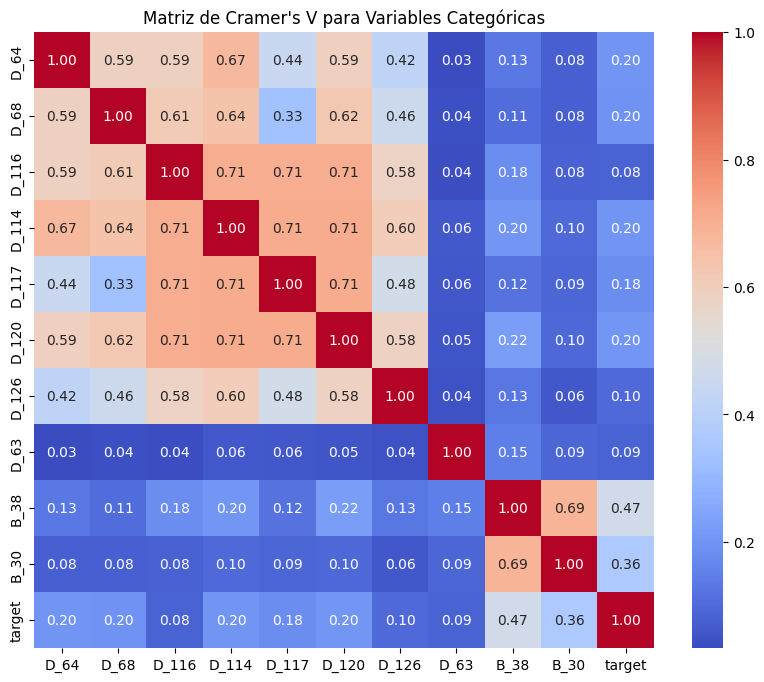

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Cramer\'s V para Variables Categóricas')
plt.show()

Con base a la matriz de asociación de variables categóricas, se puede indicar que las variables candidatas a ser eliminadas son:
- D_120
- D_114
- D_116
- B_30

#### Correlaciones numéricas

La siguiente matriz de correlación permite establecer o visualizar la correlación numérica entre las variavles del conjunto de datos imputado, se observa que la mayoría de estas no presenta alta multicolinealidad sino, por el contrario, un comportamiento de idependencia entre las mismas.

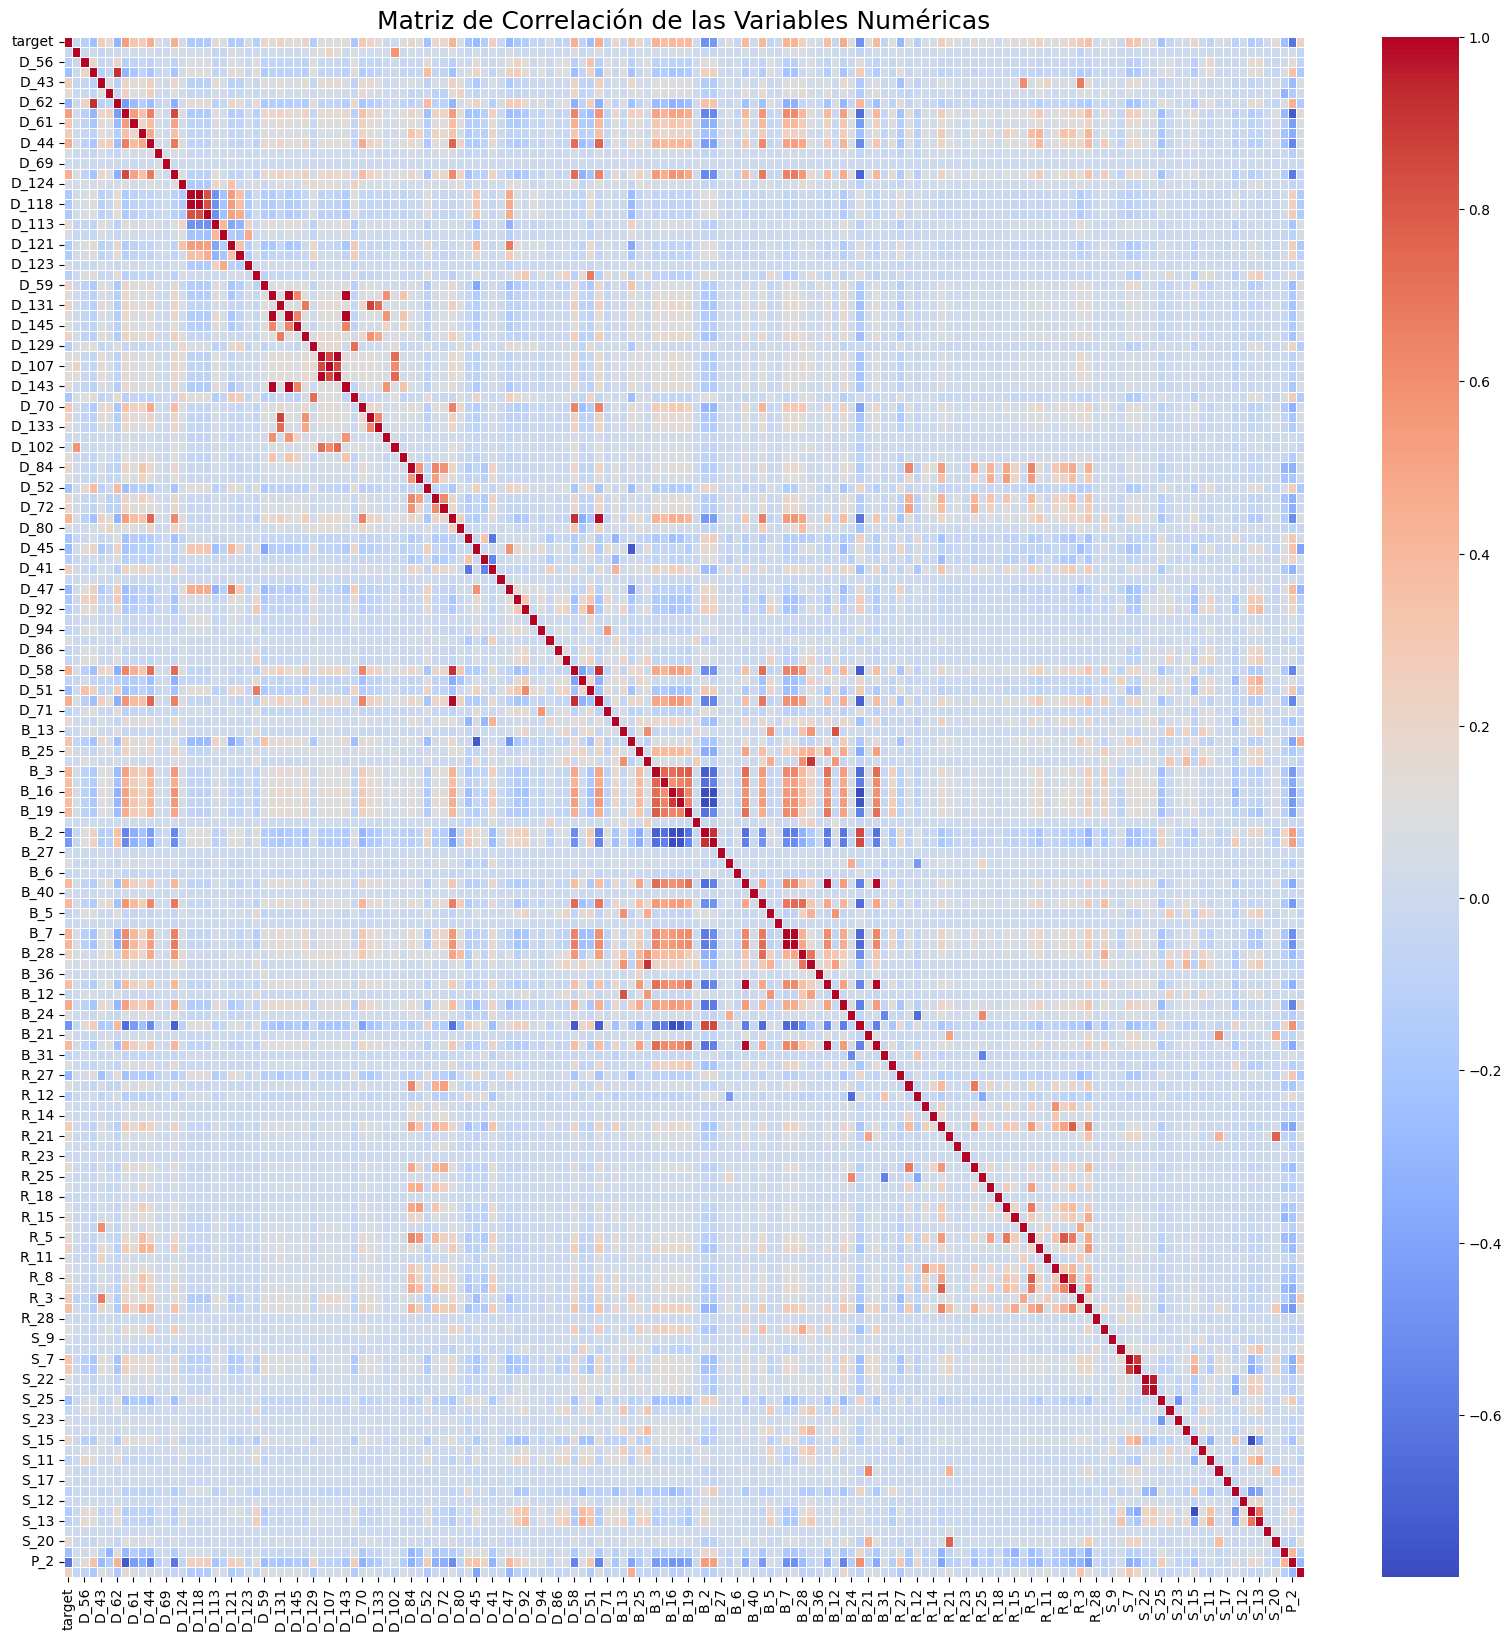

In [ ]:
# Seleccionar solo las columnas numéricas del DataFrame en pandas
final_data_numeric = final_data_with_categoricals.select_dtypes(include=[np.number])

# Resetear el índice del DataFrame de pandas para asegurar unicidad
final_data_numeric = final_data_numeric.reset_index(drop=True)

# Calcular la matriz de correlación con pandas
correlation_matrix = final_data_numeric.corr()

plt.figure(figsize=(20, 20))  # Aumentar el tamaño del gráfico
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)
plt.title('Matriz de Correlación de las Variables Numéricas', fontsize=18)
plt.show()

#### VIF - Factor de inflación de la varianza

$$VIF = \frac{1}{1-R^2}$$

Así, cuanto más se acerque el valor de
 a 1, mayor será el valor de VIF y mayor la multicolinealidad con la variable independiente concreta.

 - Un valor VIF de 1: Sin multicolinealidad (variable perfectamente independiente).

- Un valor VIF entre 1 y 5: Multicolinealidad baja a moderada (no se considera problemática).

- Un valor VIF entre 5 y 10: Multicolinealidad moderada a alta (considerada problemática).

- Un valor VIF superior a 10: Multicolinealidad alta (preocupación grave, requiere medidas).

### Verificación de multicolinealidad

Calcularemos de manera separada por grupos de variables cada factor de imflación de la varianza, la función que permite realizar eso muestra en cada iteración la tabla con el VIF calculado y el top 10 de los valores más elevados, elimina iterativamente la variable que posee más multicolinealidad y recalcula para las variables restantes el VIF nuevamente. Repite el proceso hasta que ya no quede VIF > 10.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Función para calcular el VIF, filtrando solo las columnas numéricas
def calculate_vif(df):
    # Reemplazar NaN con la mediana de cada columna
    df = df.fillna(df.median())

    # Filtrar solo columnas numéricas
    numeric_cols = df.select_dtypes(include=['number']).columns
    vif_data = pd.DataFrame()
    vif_data['Variable'] = numeric_cols
    vif_data['VIF'] = [variance_inflation_factor(df[numeric_cols].values, i) for i in range(len(numeric_cols))]
    return vif_data

# Función para eliminar columnas categóricas
def remove_categorical_columns(df, categorical_columns):
    return df.drop(columns=[col for col in categorical_columns if col in df.columns])

# Función para eliminar variables con alto VIF
def eliminate_high_vif(df, threshold=10):
    iteration = 1
    while True:
        # Calcular el VIF solo para las columnas numéricas
        vif_df = calculate_vif(df)

        # Mostrar el top 10 de las variables con mayor VIF
        top_vif = vif_df.sort_values(by='VIF', ascending=False).head(10)
        print(f"\nTop 10 de VIF - Iteración {iteration}:")
        print(top_vif)

        # Identificar la variable con el mayor VIF
        max_vif_variable = top_vif.iloc[0]['Variable']
        max_vif_value = top_vif.iloc[0]['VIF']

        # Si la variable con el VIF más alto es menor que el umbral, terminamos
        if max_vif_value < threshold:
            print(f"Todas las variables tienen VIF < {threshold}. Se detiene el proceso.")
            break

        # Eliminar la variable con mayor VIF
        print(f"\nEliminando la variable '{max_vif_variable}' con VIF={max_vif_value:.2f}")
        df = df.drop(columns=[max_vif_variable])

        # Mostrar la tabla de VIF después de cada eliminación
        print(f"\nTabla de VIF después de eliminar '{max_vif_variable}':")
        print(vif_df.sort_values(by='VIF', ascending=False))

        # Incrementar el contador de iteración
        iteration += 1

    return df

# Procesar el cálculo de VIF para cada grupo y eliminar las columnas categóricas
def process_vif_for_group(df, group_name, categorical_columns):
    print(f"\nProcesando VIF para el grupo: {group_name}")

    # Eliminar columnas categóricas
    df_filtered = remove_categorical_columns(df, categorical_columns)

    # Calcular y eliminar variables con alto VIF
    final_group_df = eliminate_high_vif(df_filtered)

    return final_group_df


Para el grupo de variables de Balance quedaron 27 variables con las que se trabajará.

In [ ]:
# Definir los grupos de datos que tienes
balance_df_filtered = process_vif_for_group(balance_imputed_pd, "Balance", categorical_columns)

# Mostrar el resultado final de uno de los grupos
print("\nVariables restantes en el grupo Delinquency después del cálculo de VIF:")
print(balance_df_filtered.head())



Procesando VIF para el grupo: Balance

Top 10 de VIF - Iteración 1:
   Variable          VIF
23     B_14  5358.534702
3      B_15  3934.123768
2      B_25  1025.296713
31      B_1   430.334854
21     B_23   390.789126
20      B_7   380.687271
25     B_11   271.540053
15     B_37   147.046785
32     B_31    36.485644
10      B_2    29.881377

Eliminando la variable 'B_14' con VIF=5358.53

Tabla de VIF después de eliminar 'B_14':
   Variable          VIF
23     B_14  5358.534702
3      B_15  3934.123768
2      B_25  1025.296713
31      B_1   430.334854
21     B_23   390.789126
20      B_7   380.687271
25     B_11   271.540053
15     B_37   147.046785
32     B_31    36.485644
10      B_2    29.881377
29     B_18    26.072098
11     B_33    21.243212
22     B_28    10.665605
6      B_16    10.548509
7      B_20     8.873577
17      B_4     6.864813
4       B_3     6.239872
8      B_19     4.657029
12     B_27     3.759195
0      B_13     3.707134
26     B_12     3.317593
5      B_22     3

Para el grupo de variables de Risk quedaron 23 variables con las que se trabajará.

In [ ]:
risk_df_filtered = process_vif_for_group(risk_imputed_pd, "Risk", categorical_columns)

# Mostrar el resultado final de uno de los grupos
print("\nVariables restantes en el grupo Delinquency después del cálculo de VIF:")
print(risk_df_filtered.head())


Procesando VIF para el grupo: Risk

Top 10 de VIF - Iteración 1:
   Variable        VIF
16      R_5  16.859688
2      R_12  14.537378
23      R_1  10.097198
0      R_27   8.905230
20      R_8   7.688986
13     R_13   5.401497
21      R_4   5.314055
11     R_17   5.176736
5       R_2   4.588230
9      R_24   3.308440

Eliminando la variable 'R_5' con VIF=16.86

Tabla de VIF después de eliminar 'R_5':
   Variable        VIF
16      R_5  16.859688
2      R_12  14.537378
23      R_1  10.097198
0      R_27   8.905230
20      R_8   7.688986
13     R_13   5.401497
21      R_4   5.314055
11     R_17   5.176736
5       R_2   4.588230
9      R_24   3.308440
12     R_18   3.275168
17     R_10   2.732785
19      R_6   2.069323
14     R_15   1.948152
1      R_20   1.911374
22      R_3   1.910855
6      R_21   1.824909
3       R_7   1.666242
15     R_16   1.454766
25     R_19   1.267615
4      R_14   1.211125
18     R_11   1.188776
10     R_25   1.098611
8      R_23   1.094775
7      R_22   1.06365

Para el grupo de variables de Spend quedaron 18 variables con las que se trabajará.

In [ ]:
spend_df_filtered = process_vif_for_group(spend_imputed_pd, "Spend", categorical_columns)

# Mostrar el resultado final de uno de los grupos
print("\nVariables restantes en el grupo Delinquency después del cálculo de VIF:")
print(spend_df_filtered.head())


Procesando VIF para el grupo: Spend

Top 10 de VIF - Iteración 1:
   Variable        VIF
4      S_22  27.412734
5      S_24  23.273877
3       S_3  16.613958
6      S_25  15.129516
2       S_7  13.538254
10     S_15   9.697886
17      S_8   7.974427
12     S_11   5.925748
18     S_13   4.683235
19     S_19   3.560024

Eliminando la variable 'S_22' con VIF=27.41

Tabla de VIF después de eliminar 'S_22':
   Variable        VIF
4      S_22  27.412734
5      S_24  23.273877
3       S_3  16.613958
6      S_25  15.129516
2       S_7  13.538254
10     S_15   9.697886
17      S_8   7.974427
12     S_11   5.925748
18     S_13   4.683235
19     S_19   3.560024
1      S_27   2.195583
16     S_12   1.995826
15      S_6   1.851806
0       S_9   1.382126
8      S_23   1.244610
20     S_20   1.229782
13     S_16   1.171490
11     S_18   1.140237
9       S_5   1.115654
7      S_26   1.095688
14     S_17   1.044328

Top 10 de VIF - Iteración 2:
   Variable        VIF
3       S_3  16.613759
5      S_25

Para el grupo de variables de Payment quedaron 3 variables con las que se trabajará.

In [ ]:
payment_df_filtered = process_vif_for_group(payment_imputed_pd, "Payment", categorical_columns)

# Mostrar el resultado final de uno de los grupos
print("\nVariables restantes en el grupo Delinquency después del cálculo de VIF:")
print(payment_df_filtered.head())


Procesando VIF para el grupo: Payment

Top 10 de VIF - Iteración 1:
  Variable       VIF
0      P_3  9.422532
1      P_2  8.967503
2      P_4  1.167881
Todas las variables tienen VIF < 10. Se detiene el proceso.

Variables restantes en el grupo Delinquency después del cálculo de VIF:
        P_3       P_2       P_4
0  0.736463  0.938469  0.007554
1  0.720886  0.936665  0.004832
2  0.738044  0.954180  0.006561
3  0.741813  0.960384  0.009559
4  0.691986  0.947248  0.008156


In [ ]:
# Función para agregar 'customer_ID' y 'Date' si no están presentes en un DataFrame
# def add_customer_id_and_date(df, original_data, date_source):
#     if 'customer_ID' not in df.columns:
#         if 'customer_ID' in original_data.columns:
#             df['customer_ID'] = original_data['customer_ID']
#         else:
#             raise KeyError("La columna 'customer_ID' no se encuentra en el DataFrame original.")

#     if 'Date' not in df.columns:
#         if 'Date' in date_source.columns:
#             df['Date'] = date_source['Date']
#         else:
#             raise KeyError("La columna 'Date' no se encuentra en el DataFrame de origen.")

#     return df

# # Función para reindexar y asegurar índices únicos
# def reset_index_unique(df):
#     df = df.reset_index(drop=True)  # Reindexar para asegurar índices únicos
#     return df

# # Asegurarse de que cada DataFrame tenga 'customer_ID' y 'Date' y que los índices sean únicos
# # Aquí paso 'data_train' para 'customer_ID' y 'data' para 'Date'
# delinquency_imputed_pd = add_customer_id_and_date(delinquency_imputed_pd, data_train, data)
# balance_df_filtered = add_customer_id_and_date(balance_df_filtered, data_train, data)
# risk_df_filtered = add_customer_id_and_date(risk_df_filtered, data_train, data)
# spend_df_filtered = add_customer_id_and_date(spend_df_filtered, data_train, data)
# payment_df_filtered = add_customer_id_and_date(payment_df_filtered, data_train, data)

# # Reindexar para asegurarnos de que no haya conflictos de índice
# delinquency_imputed_pd = reset_index_unique(delinquency_imputed_pd)
# balance_df_filtered = reset_index_unique(balance_df_filtered)
# risk_df_filtered = reset_index_unique(risk_df_filtered)
# spend_df_filtered = reset_index_unique(spend_df_filtered)
# payment_df_filtered = reset_index_unique(payment_df_filtered)

# # Concatenar todos los DataFrames horizontalmente
# final_data = pd.concat([delinquency_imputed_pd, balance_df_filtered, risk_df_filtered, spend_df_filtered, payment_df_filtered], axis=1)

# # Eliminar posibles duplicados de 'customer_ID' y 'Date' después de la concatenación
# final_data = final_data.loc[:, ~final_data.columns.duplicated()]

# # Reorganizar las columnas para colocar 'customer_ID', 'target', y 'Date' al principio
# columns_order = ['customer_ID', 'target', 'Date'] + [col for col in final_data.columns if col not in ['customer_ID', 'target', 'Date']]
# final_data = final_data[columns_order]

# # Mostrar las primeras filas del DataFrame concatenado
# print(final_data.head())

# # Confirmar si 'customer_ID' y 'Date' están presentes en el DataFrame final
# if 'customer_ID' not in final_data.columns or 'Date' not in final_data.columns:
#     raise KeyError("Las columnas 'customer_ID' o 'Date' no están presentes en el DataFrame concatenado.")

In [ ]:
 #Primero nos aseguramos de que 'customer_ID' esté presente en cada DataFrame
def add_customer_id(df, original_data):
    if 'customer_ID' not in df.columns:
        if 'customer_ID' in original_data.columns:
            df['customer_ID'] = original_data['customer_ID']
        else:
            raise KeyError("La columna 'customer_ID' no se encuentra en el DataFrame original.")
    return df

# Reindexar los DataFrames para asegurarse de que tengan índices únicos
def reset_index_unique(df):
    df = df.reset_index(drop=True)  # Reindexar para asegurar índices únicos
    return df

# Aplicar la función para agregar 'customer_ID' y asegurar índices únicos
delinquency_imputed_pd = reset_index_unique(delinquency_imputed_pd)
balance_df_filtered = reset_index_unique(balance_df_filtered)
risk_df_filtered = reset_index_unique(risk_df_filtered)
spend_df_filtered = reset_index_unique(spend_df_filtered)
payment_df_filtered = reset_index_unique(payment_df_filtered)

# Concatenar todos los DataFrames horizontalmente (por columnas)
final_data = pd.concat([delinquency_imputed_pd, balance_df_filtered, risk_df_filtered, spend_df_filtered, payment_df_filtered], axis=1)

# Eliminar posibles duplicados de 'customer_ID' si hay varias columnas tras la concatenación
final_data = final_data.loc[:, ~final_data.columns.duplicated()]

# Mostrar las primeras filas del DataFrame concatenado
print(final_data.head())


      D_105      D_56      D_77      D_43      D_46      D_62      D_48  \
0  0.893734  0.152025  0.205833  0.088512  0.358587  0.091071  0.255736   
1  0.906841  0.156201  0.205833  0.088512  0.353630  0.086805  0.223329   
2  0.928719  0.153795  0.205833  0.088512  0.334650  0.094001  0.189424   
3  0.935383  0.155772  0.205833  0.088512  0.323271  0.094854  0.135586   
4  0.953363  0.154914  0.205833  0.088512  0.231009  0.093915  0.286172   

       D_61      D_78      D_44  ...      S_17       S_6      S_12       S_8  \
0  0.308233  0.001576  0.000630  ...  0.008033  0.008322  0.272008  0.922998   
1  0.265026  0.009896  0.002526  ...  0.000760  0.002482  0.188970  0.919414   
2  0.212165  0.009629  0.007605  ...  0.004056  0.000530  0.495308  1.001977   
3  0.204300  0.008568  0.006406  ...  0.006969  0.000783  0.508670  0.704016   
4  0.175655  0.003289  0.007731  ...  0.001770  0.006698  0.216507  0.917133   

       S_13      S_19      S_20       P_3       P_2       P_4  
0  0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Lista de las variables que quedaron después del cálculo de VIF para cada grupo
# delinquency_variables = delinquency_df_filtered.columns.tolist()
balance_variables = balance_df_filtered.columns.tolist()
risk_variables = risk_df_filtered.columns.tolist()
spend_variables = spend_df_filtered.columns.tolist()
payment_variables = payment_df_filtered.columns.tolist()

# Filtrar las variables de cada grupo en los DataFrames originales (imputados)
# delinquency_imputed_filtered = spend_imputed_pd[delinquency_variables]
balance_imputed_filtered = balance_imputed_pd[balance_variables]
risk_imputed_filtered = risk_imputed_pd[risk_variables]
spend_imputed_filtered = spend_imputed_pd[spend_variables]
payment_imputed_filtered = payment_imputed_pd[payment_variables]

In [ ]:
print(balance_variables)
print(risk_variables)
print(spend_variables)
print(payment_variables)

['B_13', 'B_8', 'B_25', 'B_15', 'B_3', 'B_22', 'B_16', 'B_20', 'B_19', 'B_26', 'B_33', 'B_27', 'B_41', 'B_6', 'B_40', 'B_4', 'B_5', 'B_10', 'B_7', 'B_28', 'B_36', 'B_11', 'B_12', 'B_9', 'B_24', 'B_21', 'B_32']
['R_27', 'R_20', 'R_7', 'R_14', 'R_2', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_17', 'R_18', 'R_13', 'R_15', 'R_16', 'R_10', 'R_11', 'R_6', 'R_8', 'R_4', 'R_3', 'R_28', 'R_19']
['S_9', 'S_27', 'S_7', 'S_24', 'S_26', 'S_23', 'S_5', 'S_15', 'S_18', 'S_11', 'S_16', 'S_17', 'S_6', 'S_12', 'S_8', 'S_13', 'S_19', 'S_20']
['P_3', 'P_2', 'P_4']


# Análisis Exploratorio de los datos


In [6]:
# Ruta donde guardaste los archivos en Google Drive
input_dir = '/content/drive/My Drive/'

# Cargar los archivos CSV en DataFrames de pandas
delinquency_imputed_pd = pd.read_csv(input_dir + 'delinquency_imputed_pd.csv')
balance_imputed_filtered = pd.read_csv(input_dir + 'balance_imputed_filtered.csv')
risk_imputed_filtered = pd.read_csv(input_dir + 'risk_imputed_filtered.csv')
spend_imputed_filtered = pd.read_csv(input_dir + 'spend_imputed_filtered.csv')
payment_imputed_filtered = pd.read_csv(input_dir + 'payment_imputed_filtered.csv')


In [ ]:
def convert_to_pandas(df):
    """Convierte un DataFrame de Dask a Pandas si es necesario."""
    if isinstance(df, dd.DataFrame):
        return df.compute()
    return df

def concatenate_and_add_date(delinquency_df, balance_df, risk_df, spend_df, payment_df, data):
    # Convertir todos los DataFrames de Dask a Pandas si es necesario
    delinquency_df = convert_to_pandas(delinquency_df)
    balance_df = convert_to_pandas(balance_df)
    risk_df = convert_to_pandas(risk_df)
    spend_df = convert_to_pandas(spend_df)
    payment_df = convert_to_pandas(payment_df)
    data = convert_to_pandas(data)

    # Concatenar todos los DataFrames horizontalmente
    final_data = pd.concat([delinquency_df, balance_df, risk_df, spend_df, payment_df], axis=1)

    # Eliminar posibles duplicados de 'customer_ID' después de la concatenación
    final_data = final_data.loc[:, ~final_data.columns.duplicated()]

    # Asegurarse de que 'customer_ID' esté presente en el DataFrame concatenado
    if 'customer_ID' not in final_data.columns:
        raise KeyError("La columna 'customer_ID' no está presente en el DataFrame concatenado.")

    # Agregar la columna 'Date' desde el DataFrame 'data', basado en 'customer_ID'
    if 'Date' in data.columns and 'customer_ID' in data.columns:
        final_data = pd.merge(final_data, data[['customer_ID', 'Date']], on='customer_ID', how='left')
    else:
        raise KeyError("La columna 'Date' o 'customer_ID' no está presente en el DataFrame 'data'.")

    return final_data

# Uso de la función
final_data = concatenate_and_add_date(
    delinquency_imputed_pd,
    balance_imputed_filtered,
    risk_imputed_filtered,
    spend_imputed_filtered,
    payment_imputed_filtered,
    data  # Este es el DataFrame que contiene la columna 'Date'
)

# Mostrar las primeras filas del DataFrame final
print(final_data.head())


In [ ]:
print(final_data.columns.tolist())

['D_105', 'D_56', 'D_77', 'D_43', 'D_46', 'D_62', 'D_48', 'D_61', 'D_78', 'D_44', 'D_83', 'D_69', 'D_55', 'D_124', 'D_119', 'D_118', 'D_115', 'D_113', 'D_125', 'D_121', 'D_122', 'D_123', 'D_91', 'D_59', 'D_141', 'D_131', 'D_139', 'D_145', 'D_130', 'D_129', 'D_103', 'D_107', 'D_104', 'D_143', 'D_128', 'D_70', 'D_79', 'D_133', 'D_144', 'D_102', 'D_140', 'D_84', 'D_89', 'D_52', 'D_81', 'D_72', 'D_74', 'D_80', 'D_112', 'D_45', 'D_54', 'D_41', 'D_109', 'D_47', 'D_127', 'D_92', 'D_93', 'D_94', 'D_65', 'D_86', 'D_96', 'D_58', 'D_60', 'D_51', 'D_75', 'D_71', 'D_39', 'customer_ID', 'target', 'B_13', 'B_8', 'B_25', 'B_15', 'B_3', 'B_22', 'B_16', 'B_20', 'B_19', 'B_26', 'B_33', 'B_27', 'B_41', 'B_6', 'B_40', 'B_4', 'B_5', 'B_10', 'B_7', 'B_28', 'B_36', 'B_11', 'B_12', 'B_9', 'B_24', 'B_21', 'B_32', 'R_27', 'R_20', 'R_7', 'R_14', 'R_2', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_17', 'R_18', 'R_13', 'R_15', 'R_16', 'R_10', 'R_11', 'R_6', 'R_8', 'R_4', 'R_3', 'R_28', 'R_19', 'S_9', 'S_27', 'S_7', '

In [ ]:
filas  = len(final_data)
columnas = len(final_data.columns)
print("Número de filas:", filas)
print("Número de columnas:", columnas)

## Visualización descriptiva

### Variable Objetivo

### Variables predictoras numéricas

A continuación se presentan las estadísticas descriptivas del conjunto de datos para conocer su distribución y densidad. En primera instancia se indaga sobre su curtosis, simetría, media, mediana, apuntamiento, etc. Se toma el análisis de manera individual por grupo, para agilizar el procesamiento y facilitar las visualizaciones.

#### Para el grupo `Payment`

`1. P_3:`
- Media (mean): 0.5993, lo que indica que el valor promedio de la variable es cercano a 0.60.
- Mínimo (min): -1.5197, lo cual sugiere la presencia de valores negativos, posiblemente una desviación considerable en los datos.
- Primer cuartil (25%): 0.5377, indicando que el 25% de los datos tiene valores inferiores a este.
- Mediana (50%): 0.6150, lo que significa que el 50% de los valores está por debajo de 0.6150, muy cercano a la media.
- Tercer cuartil (75%): 0.6792, lo que indica que el 75% de los valores está por debajo de este umbral.
- Máximo (max): 2.4281, un valor bastante más elevado que la media.
- Simetría (Skewness): -1.1498, lo que indica que la distribución está sesgada a la izquierda, con valores más concentrados en el extremo alto de la distribución.
- Curtosis (Kurtosis): 9.9793, una curtosis elevada que sugiere la presencia de valores atípicos extremos.
- Varianza: 0.0278, consistente con una dispersión baja en los datos.
- Desviación estándar: 0.1668, indica una ligera dispersión en los datos, algo que refuerza lo indicado por la varianza.


`2. P_2:`
- Media (mean): 0.6561, ligeramente más alta que en la variable anterior.
- Desviación estándar (std): 0.2441, una dispersión más elevada que en P_3, lo que indica mayor variabilidad en los datos.
- Mínimo (min): -0.4590, con valores negativos, pero menos extremos que en P_3.
Primer cuartil (25%): 0.4803, lo que sugiere que el 25% de los valores está por debajo de este número.
- Mediana (50%): 0.6943, mostrando una concentración mayor de valores por encima de la media.
- Tercer cuartil (75%): 0.8637, lo que indica que el 75% de los valores está por debajo de este umbral.
- Máximo (max): 1.0353, mucho más cercano a la media que el máximo de P_3.
- Simetría (Skewness): -0.6261, indicando una leve asimetría hacia la izquierda.
- Curtosis (Kurtosis): 2.7609, lo que indica una distribución ligeramente más afilada que una distribución normal, pero no tanto como en P_3.
- Varianza: 0.0596, que es mayor que en P_3 y refuerza la mayor dispersión observada.
- Desviación estándar: 0.2441, consistente con una mayor variabilidad en los datos.


`3. P_4:`
- Media (mean): 0.1439, lo que sugiere que la mayoría de los datos se concentran en valores bajos.
- Mínimo (min): 0.0000, sugiriendo que hay valores nulos.
- Primer cuartil (25%): 0.0029, lo que indica que el 25% de los valores es muy bajo.
- Mediana (50%): 0.0058, que confirma que la mayor parte de los valores es muy baja.
- Tercer cuartil (75%): 0.0088, lo que también muestra una alta concentración de valores cercanos a cero.
- Máximo (max): 1.2694, un valor mucho más alto que la media, sugiriendo la presencia de valores atípicos.
- Simetría (Skewness): 2.0264, mostrando una distribución con fuerte asimetría hacia la derecha.
- Curtosis (Kurtosis): 5.1148, lo que sugiere que la distribución está fuertemente sesgada y tiene una concentración alta de valores extremos.
- Varianza: 0.1144, que es mucho mayor que en las otras dos variables, indicando una mayor dispersión en los datos.
- Desviación estándar: 0.3383, refuerza la mayor dispersión y variabilidad en comparación con las otras dos variables.

In [ ]:
from scipy.stats import skew, kurtosis

# Seleccionar solo las columnas numéricas del DataFrame
numerical_data = payment_imputed_filtered.select_dtypes(include=[np.number])

# Calcular estadísticas básicas
basic_stats = numerical_data.describe().T  # Transponer para mejor visualización

# Calcular la simetría (skewness) y curtosis
basic_stats['Skewness'] = numerical_data.apply(lambda x: skew(x.dropna()))
basic_stats['Kurtosis'] = numerical_data.apply(lambda x: kurtosis(x.dropna(), fisher=False))

# Añadir la varianza
basic_stats['Variance'] = numerical_data.var()
styled_basic_stats = basic_stats.style.format("{:.4f}") # Format to 2 decimal places
display(styled_basic_stats) # Display using IPython's display function

,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis,Variance
P_3,5531451.0000,0.5993,0.1668,-1.5197,0.5377,0.6150,0.6792,2.4281,-1.1498,9.9793,0.0278
P_2,5531451.0000,0.6561,0.2441,-0.4590,0.4803,0.6943,0.8637,1.0353,-0.6261,2.7609,0.0596
P_4,5531451.0000,0.1439,0.3383,0.0000,0.0029,0.0058,0.0088,1.2694,2.0264,5.1148,0.1144


**Distribución de las variables numéricas**

En las posiciones fuera de la diagonal, se representan las relaciones bivariadas entre dos variables diferentes. Cada punto en estos gráficos representa una observación del conjunto de datos. En la diagonal del gráfico, tenemos representaciones de la distribución de cada variable de forma individual, Esto ayuda a identificar la asimetría (skewness) y curtosis de cada variable, es decir, si tienen colas alargadas o se desvían de la normalidad.

**Distribuciones**
- `P_3`: Presenta una distribución bastante asimétrica con una alta concentración de valores alrededor de 0 y una larga cola hacia los valores negativos.
- `P_2`: Tiene una distribución más uniforme que parece tener dos picos (bimodal).
- `P_4`: Muestra una distribución muy sesgada a la derecha, con muchos valores cercanos a 0 y algunos valores más alejados hacia la derecha.


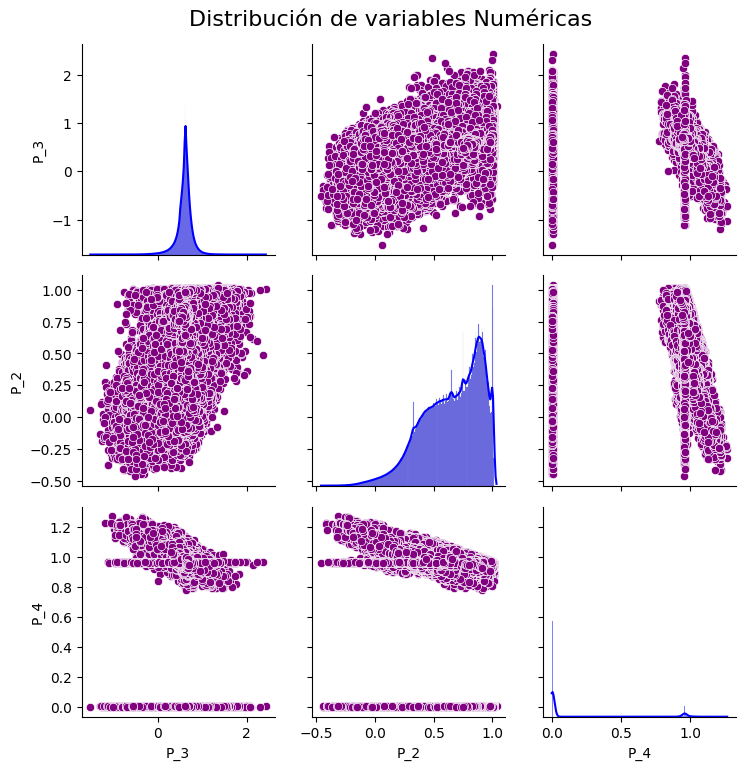

In [ ]:
# Seleccionar todas las columnas numéricas de payment_imputed_filtered
numeric_data = payment_imputed_filtered.select_dtypes(include=[np.number])

# Crear la galería de distribuciones usando seaborn PairGrid
grid = sns.PairGrid(numeric_data)
grid.map_diag(sns.histplot, kde=True, color='blue')  # Histograma en la diagonal
grid.map_offdiag(sns.scatterplot, color='purple')    # Gráficas de dispersión fuera de la diagonal

# Agregar título
plt.suptitle('Distribución de variables Numéricas', y=1.02, fontsize=16)

# Mostrar el gráfico
plt.show()

**violin plot**

1. `Gráfico de violín: P_3`

- Este gráfico tiene una forma simétrica, lo que sugiere que la distribución es relativamente equilibrada en ambos lados.
- La mayor concentración de datos está en el centro, con pocas observaciones en los extremos (los "bigotes" son cortos).
- El área más ancha alrededor de la mediana muestra que la mayoría de los valores se encuentran cerca del centro, indicando poca dispersión en los datos.
2. `Gráfico de violín: P_2`

- La distribución de P_2 es más dispersa, con una gran concentración de datos cerca de los extremos, sobre todo en la parte superior.
- La forma asimétrica y el ensanchamiento en la parte superior indican una alta concentración de valores en esa región, sugiriendo una distribución sesgada.
- Hay un rango bastante amplio de valores, con algunos extremos más alejados del centro, lo que refleja una mayor dispersión de los datos en comparación con P_3.

3. `Gráfico de violín: P_4`

- La variable P_4 presenta una distribución claramente bimodal, con dos áreas de concentración bien definidas: una en la parte inferior cercana a 0, y otra cerca de 1.
- Esto sugiere que los datos de esta variable se agrupan en dos valores principales, con pocos valores intermedios.
- El área central más estrecha indica que los valores intermedios entre esos dos puntos no son tan frecuentes.

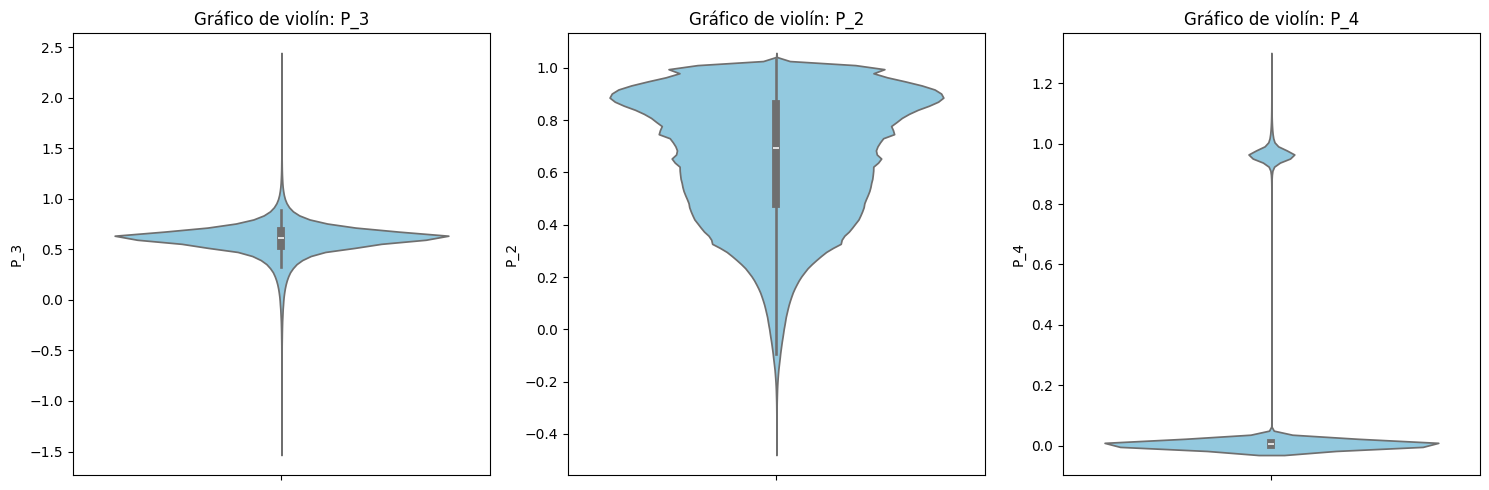

In [11]:
# Seleccionar las tres variables del conjunto payment_imputed_filtered
variables_payment = ['P_3', 'P_2', 'P_4']

# Crear el gráfico de violín para cada una de las tres variables en una fila con tres columnas
plt.figure(figsize=(15, 5))

for i, variable in enumerate(variables_payment, 1):
    plt.subplot(1, 3, i)  # 1 fila, 3 columnas, posición i
    sns.violinplot(y=payment_imputed_filtered[variable], color='skyblue')
    plt.title(f'Gráfico de violín: {variable}')

plt.tight_layout()
plt.show()

La variable P_3 presenta una distribución aproximadamente simétrica, con la mayoría de los valores concentrados alrededor de su media, aunque se observan algunos valores extremos que podrían indicar una leve asimetría negativa. Por otro lado, P_4 exhibe una distribución bimodal, con un grupo de valores acumulados cerca de 0 y otro grupo cerca de 1.

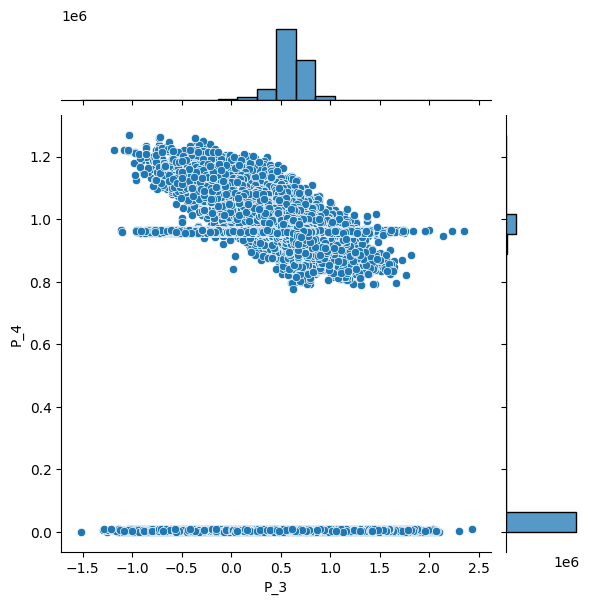

In [12]:
 data = payment_imputed_filtered
x = data['P_3']
y = data['P_4']

# Crear el scatterplot con marginal boxplots
sns.jointplot(x=x, y=y, kind="scatter", marginal_kws=dict(bins=20, fill=True))

# Mostrar el gráfico
plt.show()

El histograma de P_2 revela una distribución sesgada hacia la derecha, con la mayor concentración de datos en valores más bajos, mientras que algunos valores altos se distribuyen de manera menos frecuente. Por otro lado, P_4 también tiene una distribución bimodal similar a la gráfica anterior, con la mayoría de los puntos acumulados cerca de 0 y una mayor concentración cercana a 1

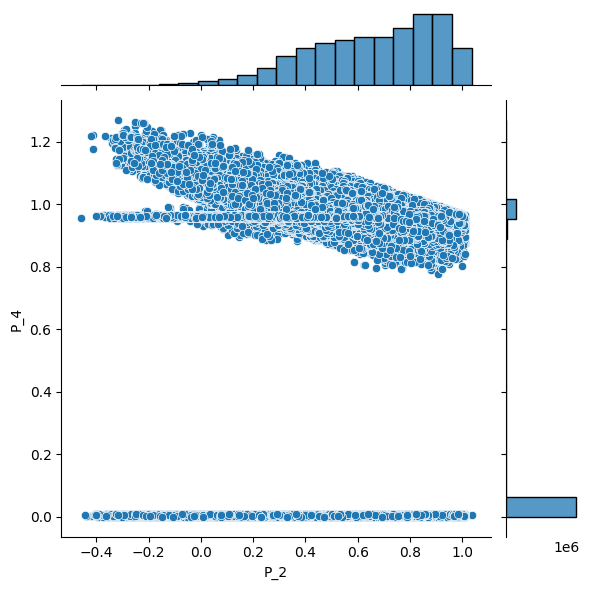

In [13]:
data = payment_imputed_filtered
x = data['P_2']
y = data['P_4']

# Crear el scatterplot con marginal boxplots
sns.jointplot(x=x, y=y, kind="scatter", marginal_kws=dict(bins=20, fill=True))

# Mostrar el gráfico
plt.show()

#### Para el grupo `spend`

`**1. Simetría (Skewness):**`

- La mayoría de las variables tienen una simetría positiva significativa, lo que sugiere que sus distribuciones están sesgadas hacia la derecha, con colas largas hacia valores más altos. Por ejemplo, las variables S_9 y S_6 tienen valores de skewness muy altos (9.68 y 78.94, respectivamente).
- Algunas variables, como S_7, presentan un skewness negativo, lo que indica colas hacia la izquierda.

2. `Curtosis`:

- Muchas variables tienen valores de curtosis elevados, lo que indica que las distribuciones tienen colas más pesadas en comparación con una distribución normal. La curtosis extremadamente alta de S_6 (11856) y S_9 (133.19) sugiere la presencia de valores atípicos extremos en esas variables.
- Otras variables, como S_16, muestran curtosis más moderada, lo que indica una distribución más cercana a lo normal.

3. `Distribución`:

- Varias variables, como S_9, S_5 y S_27, muestran rangos amplios, con diferencias marcadas entre el valor mínimo y máximo, lo que indica una alta variabilidad entre los valores observados.
- Algunas variables, como S_19, tienen distribuciones más estrechas, lo que sugiere que la mayoría de los datos se agrupan alrededor de ciertos valores con poca dispersión.

En general, el análisis sugiere la presencia de distribuciones altamente asimétricas y con colas largas, lo que indica que podría haber valores extremos significativos o patrones de distribución poco comunes en varias de las variables presentadas.

In [ ]:
# Seleccionar solo las columnas numéricas del DataFrame
numerical_data = spend_imputed_filtered.select_dtypes(include=[np.number])

# Calcular estadísticas básicas
basic_stats = numerical_data.describe().T  # Transponer para mejor visualización

# Calcular la simetría (skewness) y curtosis
basic_stats['Skewness'] = numerical_data.apply(lambda x: skew(x.dropna()))
basic_stats['Kurtosis'] = numerical_data.apply(lambda x: kurtosis(x.dropna(), fisher=False))

# Añadir la varianza
basic_stats['Variance'] = numerical_data.var()
styled_basic_stats = basic_stats.style.format("{:.4f}") # Format to 2 decimal places
display(styled_basic_stats) # Display using IPython's display function

,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis,Variance
S_9,5531451.0000,0.0796,0.1355,-1.4143,0.0215,0.0679,0.0940,2.9142,9.6876,133.1905,0.0184
S_27,5531451.0000,0.2535,0.2855,-4.5426,0.0085,0.1854,0.3988,5.4563,5.5137,69.9211,0.0815
S_7,5531451.0000,0.2190,0.1866,-0.4701,0.1004,0.1955,0.2517,3.9483,2.6043,13.8093,0.0348
S_24,5531451.0000,0.7348,0.8343,-90.4838,0.7955,0.9491,0.9715,1.0556,-63.2285,5237.7464,0.6960
S_26,5531451.0000,0.0668,0.4638,-0.1254,0.0034,0.0068,0.0110,136.6660,78.9451,11856.5547,0.2151
S_23,5531451.0000,0.1797,0.8519,-206.0855,0.1334,0.1362,0.1390,885.3349,571.8299,467933.3368,0.7258
S_5,5531451.0000,0.0881,0.4074,0.0000,0.0056,0.0135,0.0713,206.8753,102.2198,26719.2886,0.1660
S_15,5531451.0000,0.3748,0.1951,-0.3000,0.2076,0.4018,0.5048,5.3090,1.5844,18.5063,0.0381
S_18,5531451.0000,0.0315,0.1605,0.0000,0.0026,0.0051,0.0077,1.0100,5.8973,35.7902,0.0258
S_11,5531451.0000,0.3753,0.1910,-0.2000,0.2824,0.2897,0.4488,3.8014,1.5557,8.5943,0.0365


1. `Distribución de los datos:` En la mayoría de los gráficos, los datos están altamente concentrados alrededor del rango intercuartílico (entre el percentil 25 y el 75), lo que significa que la mayoría de las observaciones se encuentran en este intervalo. Las líneas horizontales dentro de las cajas representan la mediana de cada variable.

2. ` Valores atípicos (outliers):` Cada gráfico muestra puntos fuera de los "bigotes" del diagrama, que son posibles outliers. Esto es visible en todas las variables, lo que indica que existen valores extremos que están significativamente alejados de la mediana. En particular, variables como S_26, S_23, y S_9 muestran una gran cantidad de outliers.

3. `Simetría`: Algunas variables parecen estar distribuidas de manera más simétrica, mientras que otras, como S_23 y S_26, presentan una mayor asimetría, con valores más extendidos hacia los valores altos. Esta asimetría se refleja en la longitud de los bigotes, que no son simétricos con respecto a la mediana.

4.` Rangos extremos:` En variables como S_23 y S_26, los rangos son mucho más amplios en comparación con las otras variables, lo que indica que los datos tienen una dispersión mucho mayor en estas columnas.

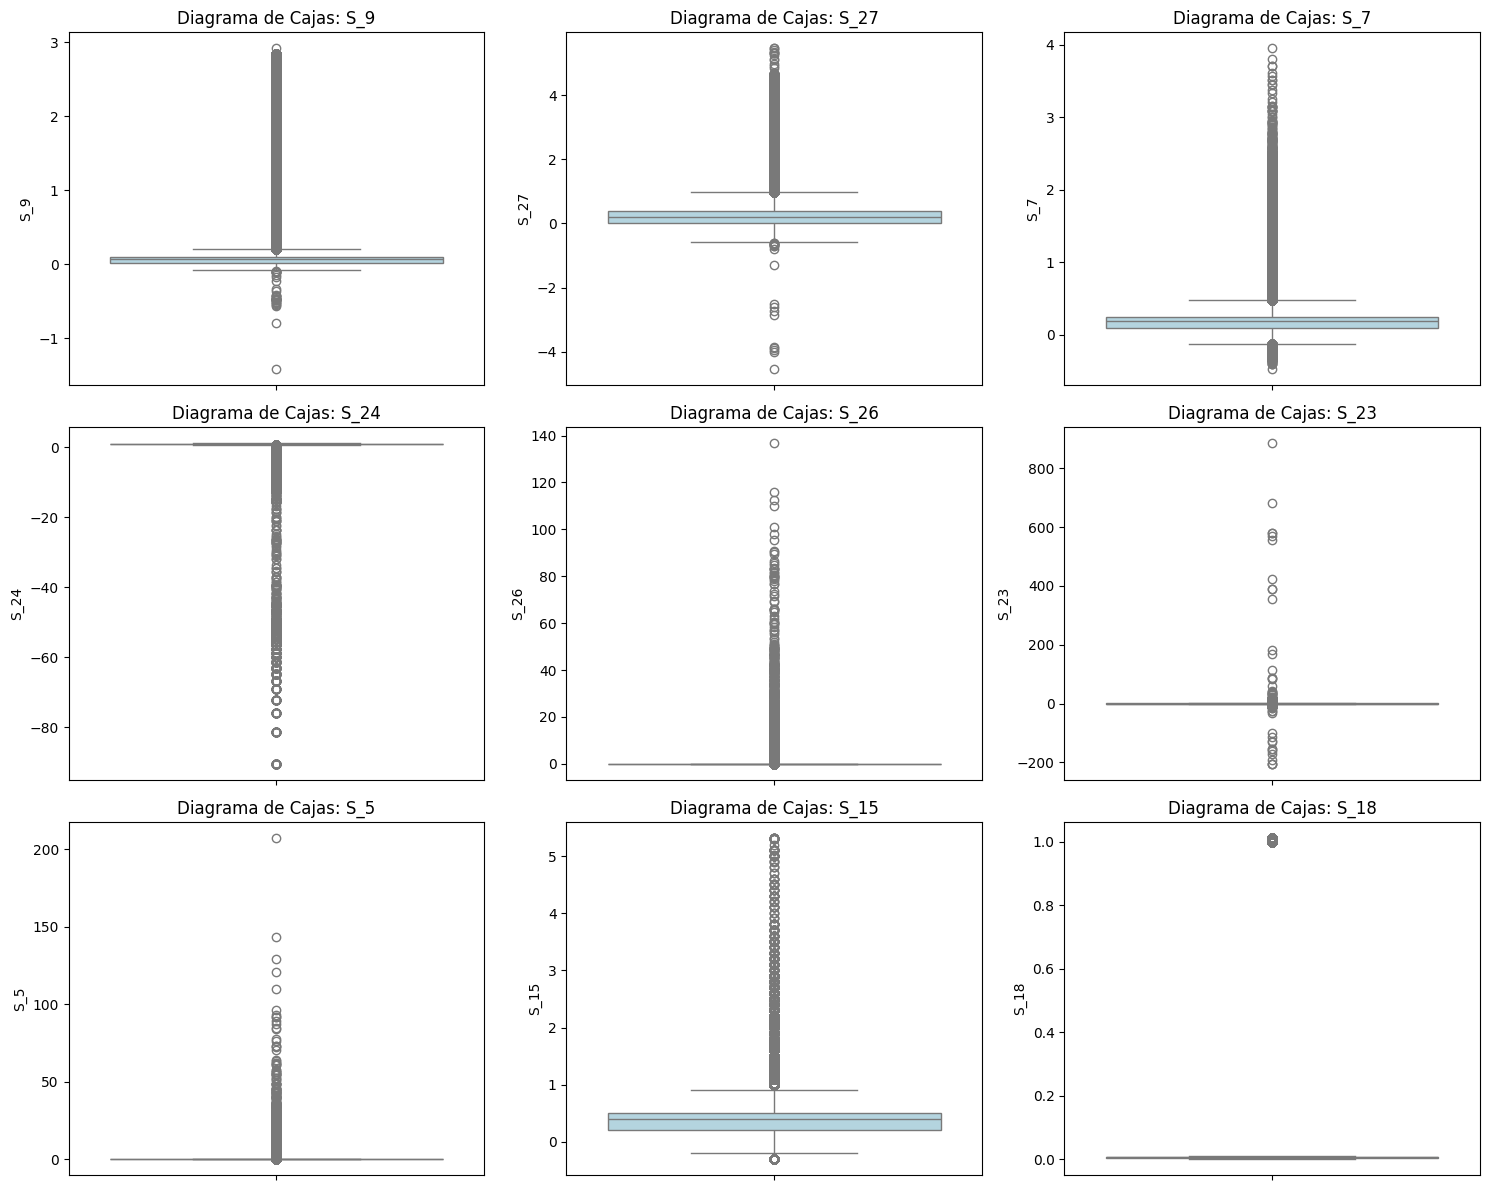

In [9]:
# Seleccionar solo las columnas numéricas del DataFrame
numerical_data = spend_imputed_filtered.select_dtypes(include=[np.number])

# Crear una figura con un layout de 3 filas y 3 columnas
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # Ajustar el tamaño de la figura

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Iterar sobre las primeras 9 columnas numéricas y crear un boxplot para cada una
for i, col in enumerate(numerical_data.columns[:9]):
    sns.boxplot(y=numerical_data[col], ax=axes[i], color='lightblue')  # Boxplot de cada variable
    axes[i].set_title(f'Diagrama de Cajas: {col}')  # Título para cada gráfico

# Ajustar la distribución de los gráficos
plt.tight_layout()
plt.show()

#### Para el grupo `Risk`

La mayoría de los datos tienen un rango limitado con una alta concentración cerca del valor central (mediana) y pocos valores extremos. Las medidas de asimetría (Skewness) y curtosis (Kurtosis) revelan la naturaleza de las distribuciones:

- Asimetría: Varias variables muestran asimetría positiva o negativa. Por ejemplo, R_27 tiene una asimetría negativa (-2.46), lo que sugiere que la distribución tiene una cola hacia la izquierda, mientras que R_22 tiene una asimetría altamente positiva (7.55), indicando una fuerte acumulación en valores bajos con una cola hacia la derecha.

- Curtosis: La curtosis es muy elevada en muchas variables, como R_7 (curtosis de 7409.44) y R_19 (curtosis de 1316.45), lo que indica distribuciones con colas largas o picos muy pronunciados, reflejando la presencia de valores atípicos extremos.

- Desviación estándar: Las variables como R_7 y R_13 tienen una mayor desviación estándar (indicando mayor dispersión de los datos), mientras que variables como R_22 y R_16 tienen menor desviación, sugiriendo datos más concentrados alrededor de la media.

- Varianza: La varianza varía entre las variables, con valores más altos en variables como R_7 (varianza de 2.40) y más bajos en R_16 (0.0042), lo que indica diferencias en la dispersión de los datos.

In [15]:
from scipy.stats import skew, kurtosis

# Seleccionar solo las columnas numéricas del DataFrame
numerical_data = risk_imputed_filtered.select_dtypes(include=[np.number])

# Calcular estadísticas básicas
basic_stats = numerical_data.describe().T  # Transponer para mejor visualización

# Calcular la simetría (skewness) y curtosis
basic_stats['Skewness'] = numerical_data.apply(lambda x: skew(x.dropna()))
basic_stats['Kurtosis'] = numerical_data.apply(lambda x: kurtosis(x.dropna(), fisher=False))

# Añadir la varianza
basic_stats['Variance'] = numerical_data.var()
styled_basic_stats = basic_stats.style.format("{:.4f}") # Format to 2 decimal places
display(styled_basic_stats) # Display using IPython's display function

,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis,Variance
R_27,5531451.0000,0.8929,0.3093,-1.5917,1.0013,1.0042,1.0071,2.3942,-2.4598,7.0939,0.0957
R_20,5531451.0000,0.0369,0.3781,-0.0365,0.0025,0.0051,0.0076,45.0060,25.6217,1104.4660,0.1429
R_7,5531451.0000,0.0881,1.5509,-0.0336,0.0026,0.0051,0.0077,449.9889,59.3149,7409.4368,2.4052
R_14,5531451.0000,0.2414,8.3565,-0.0132,0.0025,0.0051,0.0076,4837.3049,135.1334,38611.4643,69.8303
R_2,5531451.0000,0.0475,0.2018,0.0000,0.0026,0.0052,0.0078,1.0100,4.5334,21.5572,0.0407
R_21,5531451.0000,0.0216,0.1278,0.0000,0.0025,0.0051,0.0076,1.0100,7.5580,58.1551,0.0163
R_22,5531451.0000,0.0086,0.0600,0.0000,0.0025,0.0050,0.0075,1.0100,16.5062,274.0942,0.0036
R_23,5531451.0000,0.0053,0.0174,0.0000,0.0025,0.0050,0.0075,1.0100,55.7497,3196.6688,0.0003
R_24,5531451.0000,0.0189,0.1172,0.0000,0.0025,0.0051,0.0076,1.0100,8.2908,69.7822,0.0137
R_25,5531451.0000,0.0082,0.0566,0.0000,0.0025,0.0050,0.0075,1.0100,17.5084,308.3552,0.0032


Histogramas

In [ ]:
# Lista de las variables de Risk para las que quieres hacer histogramas
risk_columns = ['R_1', 'R_2', 'R_3', 'R_4']  # Cambia estas columnas según tu data

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Lista de los nombres de las variables para los títulos
risk_titles = ['R_1', 'R_2', 'R_3', 'R_4']

# Iterar sobre las columnas y los ejes para crear los histogramas
for i, col in enumerate(risk_columns):
    row = i // 2
    col_idx = i % 2
    sns.histplot(risk_imputed_filtered[col], kde=True, bins=30, ax=axes[row, col_idx], color="skyblue")
    axes[row, col_idx].set_title(f'Histograma: {risk_titles[i]}')

# Ajustar el layout
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### Para el grupo `Balance`

1. Distribución General:

- La mayoría de las variables tienen medias muy bajas, lo que indica que están centradas alrededor de valores cercanos a cero.
- Las variables como B_13 y B_9 muestran valores de skewness altamente positivos (178.58 y 16.58, respectivamente), lo que sugiere que sus distribuciones tienen colas largas hacia la derecha, con una concentración significativa de datos en valores bajos.
- Por otro lado, variables como B_2 y B_5 tienen distribuciones relativamente más equilibradas, con valores de skewness más cercanos a cero (indicando simetría o una menor inclinación de la distribución).

2. Dispersión y Valores Extremos:

- Las desviaciones estándar más altas se observan en variables como B_3 (2.5867) y B_8 (1.4798), lo que indica una mayor variabilidad de los datos en comparación con otras variables.
- En cuanto a valores máximos, algunas variables presentan outliers significativos. Por ejemplo, B_13 tiene un valor máximo de 276.18, lo que resalta una gran diferencia en comparación con otras observaciones de la misma variable. Otros valores máximos inusualmente altos son observados en B_9 y B_4.

3. Simetría y Curtosis:
- Muchas de las variables muestran asimetría positiva (skewness), como en B_12 y B_14, lo que significa que tienen colas a la derecha, mientras que algunas, como B_5, tienen skewness negativo, lo que indica que los valores bajos son más frecuentes.
- Las variables como B_13 y B_9 tienen curtosis extremadamente alta, lo que sugiere que tienen distribuciones leptocúrticas con picos pronunciados y colas largas, lo que indica la presencia de outliers.

4. Varianza:
- Las varianzas también muestran patrones interesantes, con algunas variables como B_8 presentando una varianza alta (2.1890), mientras que otras, como B_16, tienen una varianza muy baja (0.0861).
-  Las variables con mayor varianza tienden a estar más dispersas, mientras que las que tienen varianza baja están más concentradas alrededor de la media.
5. Anomalías:
- Variables como B_3 y B_9 tienen valores máximos muy superiores al percentil 75%, lo que indica la presencia de valores atípicos que podrían influir significativamente en el análisis.

In [16]:
# Seleccionar solo las columnas numéricas del DataFrame
numerical_data = balance_imputed_filtered.select_dtypes(include=[np.number])

# Calcular estadísticas básicas
basic_stats = numerical_data.describe().T  # Transponer para mejor visualización

# Calcular la simetría (skewness) y curtosis
basic_stats['Skewness'] = numerical_data.apply(lambda x: skew(x.dropna()))
basic_stats['Kurtosis'] = numerical_data.apply(lambda x: kurtosis(x.dropna(), fisher=False))

# Añadir la varianza
basic_stats['Variance'] = numerical_data.var()
styled_basic_stats = basic_stats.style.format("{:.4f}") # Format to 2 decimal places
display(styled_basic_stats) # Display using IPython's display function

,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis,Variance
B_13,5531451.0000,0.1002,0.5569,-1.3979,0.0093,0.0295,0.0888,276.1778,178.5860,66860.9739,0.3101
B_8,5531451.0000,0.4509,0.4962,-2.8878,0.0045,0.0091,1.0042,2.6499,0.2178,1.0513,0.2462
B_25,5531451.0000,0.1038,0.2090,-11.2536,0.0060,0.0198,0.1061,15.6998,5.1892,81.7152,0.0437
B_15,5531451.0000,0.0528,0.3004,-10.0080,0.0031,0.0062,0.0093,65.0374,38.5571,3574.6407,0.0902
B_3,5531451.0000,0.1325,0.2350,0.0000,0.0052,0.0098,0.1551,1.6253,2.2186,7.5002,0.0552
B_22,5531451.0000,0.1072,0.2232,0.0000,0.0031,0.0062,0.0092,3.5078,2.2443,8.9513,0.0498
B_16,5531451.0000,0.3486,0.4023,-0.0367,0.0062,0.0918,0.7566,1.0100,0.6943,1.7644,0.1618
B_20,5531451.0000,0.2363,0.3736,0.0000,0.0040,0.0081,0.3578,1.0100,1.3061,2.9935,0.1396
B_19,5531451.0000,0.1502,0.2896,-1.0832,0.0035,0.0069,0.0958,1.0485,1.9224,5.2984,0.0839
B_26,5531451.0000,0.0906,2.5877,-2.3525,0.0026,0.0052,0.0079,1499.2203,210.3830,83790.8698,6.6964


Regplot

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de las variables de Balance para las que quieres hacer regplots
balance_columns = ['B_3', 'B_4', 'B_5', 'B_6']  # Cambia estas columnas según tu data

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Lista de los nombres de las variables para los títulos
balance_titles = ['B_3', 'B_4', 'B_5', 'B_6']

# Iterar sobre las columnas y los ejes para crear los gráficos de regplot
for i, col in enumerate(balance_columns):
    row = i // 2
    col_idx = i % 2
    sns.regplot(x=balance_imputed_filtered[col], y=delinquency_imputed_pd['target'], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Regplot: {balance_titles[i]} vs target')

# Ajustar el layout
plt.tight_layout()

# Mostrar el gráfico
plt.show()



KeyboardInterrupt: 

#### Para el grupo `Delinquency`

1. Promedios y dispersión: Muchas variables tienen promedios cercanos a valores bajos (alrededor de 0.1 a 0.5), pero las desviaciones estándar varían significativamente entre las columnas, lo que sugiere niveles de dispersión diferentes en los datos. Algunas variables, como `D_61` y `D_65`, tienen desviaciones estándar extremadamente altas, lo que indica una gran variabilidad en esos campos.

2. Distribuciones asimétricas: Muchas de las variables presentan una alta asimetría (skewness), con valores de simetría que van desde positivos moderados hasta extremadamente altos, como en el caso de `D_65`, que muestra una asimetría de 259.7, lo que sugiere que los valores están concentrados en un extremo del rango. También hay variables con simetría negativa, como D_121, lo que indica una distribución asimétrica hacia el otro lado.

3. Curtosis elevada: La curtosis (kurtosis) es bastante alta en muchas variables, especialmente en `D_65` y `D_69`, que muestran valores extremadamente elevados (259.7 y 727.6 respectivamente), lo que sugiere la presencia de valores atípicos extremos o distribuciones con colas más pesadas.

4. Outliers: Los valores máximos en muchas de las variables son bastante grandes comparados con el percentil 75, lo que indica la presencia de valores atípicos significativos. Esto es especialmente evidente en `D_69` y D_65, que tienen máximos muy superiores a los valores típicos.

5. Varianza: La varianza es baja en muchas de las variables, lo que indica una baja dispersión de los datos. Sin embargo, algunas variables como D_61 y `D_69` muestran una varianza considerablemente alta, lo que coincide con la alta desviación estándar observada.

In [8]:
 from scipy.stats import skew, kurtosis

# Seleccionar solo las columnas numéricas del DataFrame
numerical_data = delinquency_imputed_pd.select_dtypes(include=[np.number])

# Calcular estadísticas básicas
basic_stats = numerical_data.describe().T  # Transponer para mejor visualización

# Calcular la simetría (skewness) y curtosis
basic_stats['Skewness'] = numerical_data.apply(lambda x: skew(x.dropna()))
basic_stats['Kurtosis'] = numerical_data.apply(lambda x: kurtosis(x.dropna(), fisher=False))

# Añadir la varianza
basic_stats['Variance'] = numerical_data.var()
styled_basic_stats = basic_stats.style.format("{:.4f}") # Format to 2 decimal places
display(styled_basic_stats) # Display using IPython's display function

,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis,Variance
D_105,5531451.0000,0.3503,0.1697,-0.0264,0.3338,0.3338,0.3338,5.6317,1.7111,15.3702,0.0288
D_56,5531451.0000,0.1744,0.1463,-0.0171,0.1494,0.1494,0.1494,10.9565,10.2488,327.6714,0.0214
D_77,5531451.0000,0.2335,0.1737,0.0000,0.1901,0.2058,0.2255,10.2292,4.5103,98.7803,0.0302
D_43,5531451.0000,0.1348,0.1811,0.0000,0.0590,0.0885,0.1323,10.1116,6.7743,107.1508,0.0328
D_46,5531451.0000,0.4720,0.1503,-17.2893,0.4374,0.4597,0.4947,16.3199,0.8947,183.1399,0.0226
D_62,5531451.0000,0.1775,0.2164,-0.0028,0.0373,0.0944,0.2418,11.1010,3.6786,61.3478,0.0468
D_48,5531451.0000,0.3692,0.3062,-0.0096,0.0992,0.2862,0.6073,8.9714,0.7378,3.8186,0.0938
D_61,5531451.0000,0.4234,0.4957,-0.0093,0.1114,0.3723,0.7353,868.5154,972.8685,1700776.7572,0.2457
D_78,5531451.0000,0.0598,0.2531,0.0000,0.0028,0.0054,0.0080,16.0086,7.9309,103.3908,0.0641
D_44,5531451.0000,0.1129,0.2171,0.0000,0.0040,0.0077,0.1310,5.6347,3.1445,17.4498,0.0471


ScatterPlot

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de las variables de Delinquency para las que quieres hacer scatterplots
delinquency_columns = ['D_1', 'D_2', 'D_3', 'D_4']  # Cambia estas columnas según tu data

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Lista de los nombres de las variables para los títulos
delinquency_titles = ['D_1', 'D_2', 'D_3', 'D_4']

# Iterar sobre las columnas y los ejes para crear los scatterplots
for i, col in enumerate(delinquency_columns):
    row = i // 2
    col_idx = i % 2
    sns.scatterplot(x=delinquency_imputed_pd[col], y=delinquency_imputed_pd['target'], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Scatterplot: {delinquency_titles[i]} vs target')

# Ajustar el layout
plt.tight_layout()

# Mostrar el gráfico
plt.show()
